# Assessment
### Urban Simulation
---

Felipe Santos Almeida @ucfnant

SN: 21125032

## Tips

- Use table to summarise information
- Part 1 and Part 2 are equally weighted
- Put the code in the Git Hub
- we need to use the networking from the practical 10

## Doubts

- What is the difference between Betweenness Centrality and Topological Betweenness Centrality?
- What is the purpose to understand diameter measure in a network? How is the best way to understand in London Underground?
- What is the difference between Degree as a global measure and Degree centrality? Is it the same thing?
- If I want to use the clustering as measure, I am not sure how to calculate that into the tube networking and also understand the meaning of this measures into tube networking as a global measure

- Diameter is the longest shortest path


- Can I affirm the clusttering is the oposite of degree( degree most vulnerable -  clustering less vulnerable)? maybe I can make this relationship because clustering is local measure and degree is a global measure


- clustering is a local measure


- degre and degree centrality are the same thing

## Data loading, wrangling and pre-processing


In [106]:
# Packages

import pandas as pd
import numpy as np
import geopandas as gpd
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
import json
import re
from shapely.geometry import Point, LineString #this library is for manipulating geometric objects, and it is what geopandas uses to store geometries
from scipy.spatial import distance
import networkx as nx
from operator import itemgetter
import seaborn as sns
import statsmodels.formula.api as smf
import statsmodels.api as sm

In [107]:
#read in the data using geopandas
stations = gpd.read_file('Data/tfl_stations.json')
lines = gpd.read_file('Data/tfl_lines.json')

In [108]:
#project data to British National Grid
#we do this so we can work in meters
stations = stations.to_crs(epsg = 27700)
lines = lines.to_crs(epsg = 27700)

In [109]:
#get all station names
station_names = {row.id: row['name'] for i, row in stations.iterrows()}

In [110]:
#clean station names
for k, v in station_names.items():
    if k == 'none':
        continue
    cleaned_name = re.sub('\sLU\s?|\sLO\s?|\sNR\s?|\sTf[lL]\s?|\sDLR\s?|\s\(.*\)', '', v)
    
    #note that bank and monument are enconded as one station in our TFL data, so we will do the same
    if cleaned_name in ['Bank', 'Monument']:
        cleaned_name = 'Bank and Monument'
    station_names[k] = cleaned_name
    
stations['name'] = stations['id'].apply(lambda x: station_names[x])

In [111]:
#get position of stations as mean of x, y of stations

#create empty dict to store list of coordinates
pos = {}

#iterate through the stations
for i, station in stations.iterrows():
    xy = station.geometry.coords[0]
    
    #if station already in dict add coordinate to coordinate list
    if station['name'] in pos.keys():
        pos[station['name']].extend([xy])
    #if station is not in the dict add station to dict and set first coordinate in list
    else:
        pos[station['name']] = [xy]

#iterate through our dict and replace coordinate list with mean value
for k, v in pos.items():
    #we set axis to 0 to make sure to take mean of x and y coordinates
    pos[k] = np.mean(v, axis=0)

In [112]:
#set new geometry
stations['geometry'] = stations['name'].apply(lambda x: Point(pos[x]))

In [113]:
#get all line types as a list and subset geoms by lines
line_names  = lines.lines.apply(lambda x: [x['name'] for x in json.loads(x)] )
line_names = list(set([item for sublist in line_names for item in sublist]))
line_names

['Thameslink 6tph line',
 'Crossrail 2',
 'Northern',
 'Emirates Air Line',
 'Victoria',
 'TfL Rail',
 'Jubilee',
 'Crossrail',
 'Central',
 'East London',
 'Hammersmith & City',
 'Tramlink',
 'Waterloo & City',
 'Metropolitan',
 'Piccadilly',
 'London Overground',
 'Bakerloo',
 'Circle',
 'DLR',
 'District']

In [114]:
#We can see that east london line is incomplete
#digging into this however we notice that it's because east london is actually part of the overground
#merge East London line and London Overground since they are one line
lines.lines = lines.lines.str.replace('East London', 'London Overground')
stations.lines = stations.lines.str.replace('East London', 'London Overground')

In [115]:
#Our TFL data doesn't include tramlink, emirates air lines, and crossrail is still in construction
#exclude the lines that we are not going to use
excluded_lines = ['Thameslink 6tph line', 'East London', 'Crossrail 2', 'Emirates Air Line', 'Crossrail', 'Tramlink']

In [116]:
#create an empty dict to hold our geometric graphs
geometric_graphs = {}

#iterate through each line individually
for line_name in line_names:
    #skip lines that we won't be using
    if line_name in excluded_lines :
        continue
    print(line_name)
    
    #subset our line and station files for the ones the belong to a specific line
    temp_lines = lines[lines.lines.str.contains(line_name)]
    temp_stations = stations[stations.lines.str.contains(line_name)]
    
    #create empty graph
    G= nx.Graph()
    
    #iterate through our line geometries
    for i, line in temp_lines.iterrows():
        #get list of coordinates that define our line
        _l = list(line.geometry.coords)

        #add coordinates as edges
        G.add_edges_from(list(zip(_l,_l[1:])))
    
    #remove any self loops
    G.remove_edges_from(nx.selfloop_edges(G))
    
    #the position of the node is the name of the node
    #let's extract this to plot our graph
    pos = {n: n for n in G.nodes()}
    
    # get degree one nodes
    D = nx.degree(G)
    k1 = [node for node,degree in D if degree==1]
    #let's plot our graph and all degree one nodes
    #nx.draw(G, pos=pos, node_size=0.5, node_color='grey')
   # nx.draw_networkx_nodes(G, pos=pos, nodelist=k1, node_color='red', node_size=8)
   # plt.show()
    
    #get distance between all points of 1-degree, this will be a matrix
    dist = distance.cdist(k1, k1)
    
    #add edges between points that are close
    for j in range(dist.shape[0]-1):
        temp = dist[j][j+1:]
        #get index of closest node
        i_min = np.argmin(temp)
        if dist[j][i_min+j+1]<50:
            G.add_edge(k1[j],k1[i_min+j+1])
    
    #recalculate degree
    D = nx.degree(G)
    k1 = [node for node,degree in D if degree==1]
    #plot new graph
   # nx.draw(G, pos=pos, node_size=0.5, node_color='grey')
   # nx.draw_networkx_nodes(G, pos=pos, nodelist=k1, node_color='red', node_size=8)
   # plt.show()
  #  print(nx.number_connected_components(G))
    #store graph in dictionary
    geometric_graphs[line_name] = G


Northern
Victoria
TfL Rail
Jubilee
Central
Hammersmith & City
Waterloo & City
Metropolitan
Piccadilly
London Overground
Bakerloo
Circle
DLR
District


In [117]:
#create a dataframe with all geometries from all valid lines
#this list will contain a dictionary for each edge in our graph that contains
# node pairs, line name, and a geometry (this is just for quick visualization purposes and will be replaced by true geometry)
edge_list = []
def _has_ids(k):
    #helper function to check if line contains id of start and end station
    if ('start_sid' in k.keys()) and ('end_sid' in k.keys()):
        return True
    else:
        return False

#iterate through each line seperately 
for line_name in line_names:
    if line_name in excluded_lines :
        continue
        
    #subset lines and stations
    temp_lines = lines[lines.lines.str.contains(line_name)]
    temp_stations = stations[stations.lines.str.contains(line_name)]
    
    #for each line in our subset dataframe get each origin and destination pair
    for i, line in temp_lines.iterrows():
        for k in json.loads(line.lines):
            if k['name'] == line_name:
                if _has_ids(k):
                    #get start and end station ids
                    start_id = k['start_sid']
                    end_id = k['end_sid']

                    #get info of start and end station
                    start_station = temp_stations[(temp_stations.id == start_id) | (temp_stations.altmodeid == start_id)].values
                    end_station = temp_stations[(temp_stations.id == end_id) | (temp_stations.altmodeid == end_id)].values
                    
                    #if no matching station exist, let's just take the starting and ending coordinate of the line for now
                    if len(start_station) >= 1 and len(end_station) >=1:
                        s_geom = start_station[0][-1].coords[0]
                        e_geom = end_station[0][-1].coords[0]
                        edge_list.append({
                            'line_name': line_name,
                            'start_id': start_id,
                            'end_id': end_id,
                            'geometry': LineString([s_geom, e_geom])
                        })

,line_name,start_id,end_id,geometry
0,Northern,940GZZLUEGW,940GZZLUBTK,"LINESTRING (519499.240 191981.653, 520328.436 ..."
1,Northern,940GZZLUBTK,940GZZLUCND,"LINESTRING (520328.436 190761.252, 521329.607 ..."
2,Northern,940GZZLUCND,940GZZLUHCL,"LINESTRING (521329.607 189951.068, 523003.022 ..."
3,Northern,940GZZLUHCL,940GZZLUBTX,"LINESTRING (523003.022 188632.091, 523889.655 ..."
4,Northern,940GZZLUBTX,940GZZLUGGN,"LINESTRING (523889.655 187937.899, 525250.358 ..."


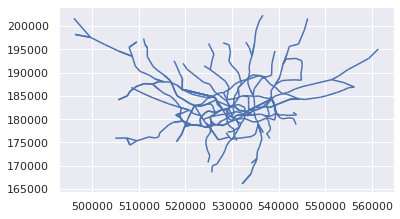

In [118]:
#turn our dictionary list into a geopandas df to quickly plot and sanity check our work
edge_gdf = gpd.GeoDataFrame(edge_list)
edge_gdf.crs = lines.crs
edge_gdf.plot()
edge_gdf.head()

In [119]:
### Add geometry information back into the graph
for line_name in line_names:
    if line_name in excluded_lines :
        continue
    temp_lines = edge_gdf[edge_gdf.line_name == line_name]
    temp_stations = stations[stations.lines.str.contains(line_name)]
    
    #let's plot our lines so we can check them
    #fig, ax = plt.subplots(figsize = (7,7))
    #fig.suptitle(f'line: {line_name}')
    #ax.set_aspect("equal")
    #ax.axis('off')
    #ax.margins(0.1)
    
    #base = temp_lines.plot(ax=ax, color='grey')
    #temp_stations.plot(ax=base, markersize=20, color='red')
   # plt.show()
    
    #add real geometry back
    for i, edge in temp_lines.iterrows():
        #get start and end of line coordinates
        start = edge.geometry.coords[0]
        end = edge.geometry.coords[-1]
        
        #let's get all the coordinates in our geometric graph
        nodes = list(geometric_graphs[line_name].nodes)
        
        #find nearest node in graph to origin and destination
        s_dist = distance.cdist([start], nodes)[0]
        s_i = np.argmin(s_dist)
        source= nodes[s_i]
        
        t_dist = distance.cdist([end], nodes)[0]
        t_i = np.argmin(t_dist)
        target= nodes[t_i]
        
        #get shortest path
        sp = nx.shortest_path(geometric_graphs[line_name], source, target)
        
        #make into geometry
        #notice how I'm also adding the start and end coordinates to the line definition
        #this fixes the problem of stations and lines not matching up
        geometry = LineString([start] + sp + [end])
        edge_gdf.loc[i, 'geometry'] = geometry

<AxesSubplot:>

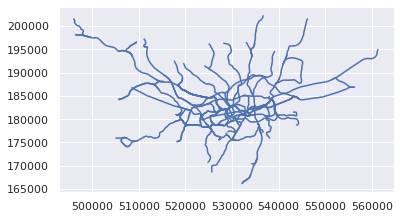

In [120]:
#plot to sanity check
edge_gdf.plot()

In [121]:
#let's store the length of the real geometry
edge_gdf['length'] = edge_gdf.geometry.length

In [122]:
#this is our resulting dataframe
edge_gdf.head()

,line_name,start_id,end_id,geometry,length
0,Northern,940GZZLUEGW,940GZZLUBTK,"LINESTRING (519499.240 191981.653, 519500.511 ...",1518.129679
1,Northern,940GZZLUBTK,940GZZLUCND,"LINESTRING (520328.436 190761.252, 520327.172 ...",1306.422050
2,Northern,940GZZLUCND,940GZZLUHCL,"LINESTRING (521329.607 189951.068, 521330.784 ...",2152.513379
3,Northern,940GZZLUHCL,940GZZLUBTX,"LINESTRING (523003.022 188632.091, 523004.146 ...",1133.607342
4,Northern,940GZZLUBTX,940GZZLUGGN,"LINESTRING (523889.655 187937.899, 523888.361 ...",1515.089103


In [123]:
#let's replace the ids with the actual nane
#get all station names
station_names_2 = {row.altmodeid: row['name'] for i, row in stations.iterrows() if row.altmodeid != None}
station_names.update(station_names_2)

In [124]:
edge_gdf['start_id'] = edge_gdf['start_id'].apply(lambda x: station_names[x])
edge_gdf['end_id'] = edge_gdf['end_id'].apply(lambda x: station_names[x])

In [125]:
edge_gdf.head()

,line_name,start_id,end_id,geometry,length
0,Northern,Edgware,Burnt Oak,"LINESTRING (519499.240 191981.653, 519500.511 ...",1518.129679
1,Northern,Burnt Oak,Colindale,"LINESTRING (520328.436 190761.252, 520327.172 ...",1306.422050
2,Northern,Colindale,Hendon Central,"LINESTRING (521329.607 189951.068, 521330.784 ...",2152.513379
3,Northern,Hendon Central,Brent Cross,"LINESTRING (523003.022 188632.091, 523004.146 ...",1133.607342
4,Northern,Brent Cross,Golders Green,"LINESTRING (523889.655 187937.899, 523888.361 ...",1515.089103


In [126]:
#now we can use this to create our network!
G = nx.from_pandas_edgelist(edge_gdf, source = 'start_id', target='end_id', edge_attr=['length', 'line_name'])

{'Piccadilly', 'London Overground', 'Central', 'Bakerloo', 'Victoria', 'Circle', 'TfL Rail', 'Jubilee', 'DLR', 'Hammersmith & City', 'District', 'Waterloo & City', 'Metropolitan', 'Northern'}


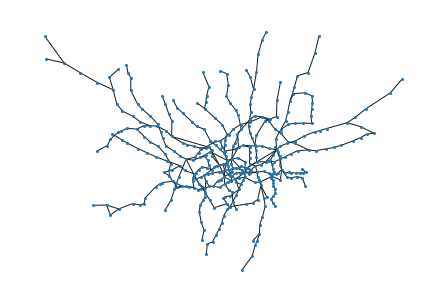

In [127]:
#let's plot
#notice that even though we created the real geometries, the graph still plots just straight line
#this is because networkx doesn't have a concept of a edge geometry
#however this is ok, since we only need the distance as weights, and that is already an attribute in our graph
pos = {row['name']: row.geometry.coords[0] for i, row in stations.iterrows() if row['name'] in G.nodes()}
Gcc = nx.connected_components(G)
for n in Gcc:
    G_sub = G.subgraph(n)
    lines = [data['line_name'] for u,v, data in G_sub.edges(data=True)]
    print(set(lines))
    nx.draw(G_sub, pos, node_size=4)
    plt.show()

In [128]:
#save position to graph
nx.set_node_attributes(G, pos, 'coords')

In [129]:
#tlf provides passenger flow data for each network separately
#we need to create a list of all the different files we need
files = ['NBT19MTT2b_od__DLR_tb_wf.csv', 
         'NBT19MTT2b_od__EZL_tb_wf.csv', 
         'NBT19MTT2b_od__LO_tb_wf.csv', 
         'NBT19MTT2b_od__LU_tb_wf.csv']

#create an empty list to store dataframes for each file
dfs = []

#iterate through our files list, read the file and append to our dataframe list
for file in files:
    dfs.append(pd.read_csv('data/' + file))
    
#merge all dataframes
london_OD = pd.concat(dfs, ignore_index=True)

In [130]:
#take a look at our data
london_OD.head()

,mode_mnlc_o,mode_mnlc_d,2,3,4,5,6,7,mode,1,8
0,504,523,8.033,16.430,24.563,28.555,13.023,2.263,DLR,NaN,NaN
1,504,533,30.719,40.105,61.571,57.881,15.573,0.317,DLR,NaN,NaN
2,504,538,5.941,17.238,37.493,43.158,33.890,10.429,DLR,NaN,NaN
3,504,559,5.795,26.397,27.285,24.065,15.213,8.508,DLR,NaN,NaN
4,504,573,77.786,113.750,143.938,387.562,165.776,65.283,DLR,NaN,NaN


In [131]:
definition_df = pd.read_excel('data/NBT19_Definitions.xlsx', 'Stations')
definition_df.head()

,MNLC,MASC,StationName,TFL?
0,500.0,ACTu,Acton Town,True
1,501.0,BARu,Barbican,True
2,502.0,ALDu,Aldgate,True
3,503.0,ALEu,Aldgate East,True
4,504.0,STId,Stratford International DLR,True


In [132]:
#we will drop any missing values from our dataframe
definition_df.dropna(inplace=True)

#transform mnlc codes from floats to int
definition_df.MNLC = definition_df.MNLC.astype(int)
definition_df.head()

,MNLC,MASC,StationName,TFL?
0,500,ACTu,Acton Town,True
1,501,BARu,Barbican,True
2,502,ALDu,Aldgate,True
3,503,ALEu,Aldgate East,True
4,504,STId,Stratford International DLR,True


In [133]:
#add the station names
london_OD['station_origin'] = london_OD['mode_mnlc_o'].apply(lambda x: definition_df[definition_df.MNLC==x]['StationName'].values[0])
london_OD['station_destination'] = london_OD['mode_mnlc_d'].apply(lambda x: definition_df[definition_df.MNLC==x]['StationName'].values[0])
london_OD.head()

,mode_mnlc_o,mode_mnlc_d,2,3,4,5,6,7,mode,1,8,station_origin,station_destination
0,504,523,8.033,16.430,24.563,28.555,13.023,2.263,DLR,NaN,NaN,Stratford International DLR,King George V
1,504,533,30.719,40.105,61.571,57.881,15.573,0.317,DLR,NaN,NaN,Stratford International DLR,London City Airport
2,504,538,5.941,17.238,37.493,43.158,33.890,10.429,DLR,NaN,NaN,Stratford International DLR,Pontoon Dock
3,504,559,5.795,26.397,27.285,24.065,15.213,8.508,DLR,NaN,NaN,Stratford International DLR,West Silvertown
4,504,573,77.786,113.750,143.938,387.562,165.776,65.283,DLR,NaN,NaN,Stratford International DLR,Woolwich Arsenal


In [134]:
# we will only keep passenger flows for the timeband we are interested in
london_OD_AMpeak = london_OD[['station_origin', 'station_destination', '3']].copy()
london_OD_AMpeak.head()

,station_origin,station_destination,3
0,Stratford International DLR,King George V,16.430
1,Stratford International DLR,London City Airport,40.105
2,Stratford International DLR,Pontoon Dock,17.238
3,Stratford International DLR,West Silvertown,26.397
4,Stratford International DLR,Woolwich Arsenal,113.750


In [135]:
#rename column
london_OD_AMpeak.rename({'3':'flows'}, axis=1, inplace=True)

#since the flows are averages the are stored as flows.
#for our analysis we will turn the into ints
london_OD_AMpeak.flows = london_OD_AMpeak.flows.astype(int)
london_OD_AMpeak.head()

,station_origin,station_destination,flows
0,Stratford International DLR,King George V,16
1,Stratford International DLR,London City Airport,40
2,Stratford International DLR,Pontoon Dock,17
3,Stratford International DLR,West Silvertown,26
4,Stratford International DLR,Woolwich Arsenal,113


In [136]:
station_origin = list(london_OD_AMpeak.station_origin.values)
station_destination = list(london_OD_AMpeak.station_destination.values)
all_stations = list(set(station_origin + station_destination))
all_stations = sorted(all_stations, key=str.lower)

In [137]:
all_stations

['Abbey Road',
 'Acton Central',
 'Acton Main Line',
 'Acton Town',
 'Aldgate',
 'Aldgate East',
 'All Saints',
 'Alperton',
 'Amersham',
 'Anerley',
 'Angel',
 'Archway',
 'Arnos Grove',
 'Arsenal',
 'Baker Street',
 'Balham LU',
 'Bank and Monument',
 'Barbican',
 'Barking',
 'Barkingside',
 'Barons Court',
 'Battersea Park',
 'Bayswater',
 'Beckton',
 'Beckton Park',
 'Becontree',
 'Belsize Park',
 'Bermondsey',
 'Bethnal Green LO',
 'Bethnal Green LU',
 'Blackfriars LU',
 'Blackhorse Road',
 'Blackwall',
 'Bond Street',
 'Borough',
 'Boston Manor',
 'Bounds Green',
 'Bow Church',
 'Bow Road',
 'Brent Cross',
 'Brentwood',
 'Brixton LU',
 'Brockley',
 'Bromley-by-Bow',
 'Brondesbury',
 'Brondesbury Park',
 'Bruce Grove',
 'Buckhurst Hill',
 'Burnt Oak',
 'Bush Hill Park',
 'Bushey',
 'Caledonian Road',
 'Caledonian Road & Barnsbury',
 'Cambridge Heath',
 'Camden Road',
 'Camden Town',
 'Canada Water',
 'Canary Wharf DLR',
 'Canary Wharf LU',
 'Canning Town',
 'Cannon Street LU',
 'C

In [138]:
london_OD_AMpeak['station_origin']= london_OD_AMpeak.station_origin.apply(lambda x: 
                                      re.sub('\sLU\s?|\sLO\s?|\sNR\s?|\sTf[lL]\s?|\sDLR\s?|\s\(.*\)', '', x)
                                     )
london_OD_AMpeak['station_destination']=london_OD_AMpeak.station_destination.apply(lambda x: 
                                      re.sub('\sLU\s?|\sLO\s?|\sNR\s?|\sTf[lL]\s?|\sDLR\s?|\s\(.*\)', '', x)
                                     )

In [139]:
#group by origin and destination station and sum the flows
london_OD_AMpeak = london_OD_AMpeak.groupby(['station_origin', 'station_destination']).sum().reset_index()

In [140]:
london_OD_AMpeak.head()

,station_origin,station_destination,flows
0,Abbey Road,Bank and Monument,0
1,Abbey Road,Beckton,1
2,Abbey Road,Blackwall,3
3,Abbey Road,Canary Wharf,1
4,Abbey Road,Canning Town,37


In [141]:
#let's sanity check and see the highest and lowest flows in and out flows
outflows = london_OD_AMpeak.groupby('station_origin').sum()

In [142]:
outflows.sort_values('flows').head(10)

,flows
station_origin,
Battersea Park,0
West India Quay,162
Cheshunt,171
Bushey,238
Heathrow Terminals 2 & 3 EL,242
South Hampstead,248
Shenfield,248
Hyde Park Corner,259
Beckton Park,293


In [143]:
outflows.sort_values('flows').tail(10)

,flows
station_origin,
Paddington,24071
Finsbury Park,24735
Canada Water,27026
King's Cross St. Pancras,28307
Bank and Monument,29494
Liverpool Street,31473
London Bridge,32597
Victoria,37517
Stratford,59311


In [144]:
#let's sanity check and see the highest and lowest flows in and out flows
inflows = london_OD_AMpeak.groupby('station_destination').sum()

In [145]:
inflows.sort_values('flows').head(10)

,flows
station_destination,
Battersea Park,0
Emerson Park,42
Acton Main Line,70
Hanwell,72
Grange Hill,76
Roding Valley,84
Beckton Park,88
West Finchley,91
Hatch End,93


In [146]:
inflows.sort_values('flows').tail(10)

,flows
station_destination,
Farringdon,25592
Green Park,26754
London Bridge,29930
Victoria,33251
King's Cross St. Pancras,33330
Oxford Circus,44368
Stratford,55954
Canary Wharf,58772
Liverpool Street,61122


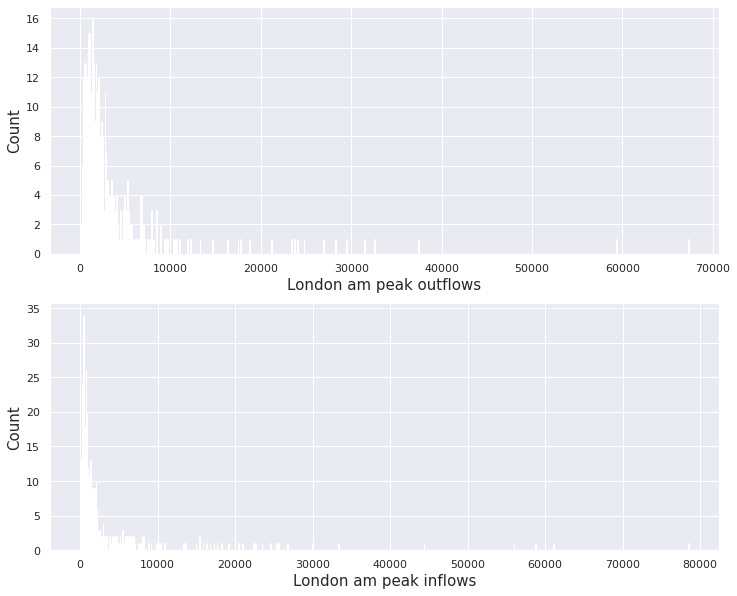

In [147]:
#let's plot this as a histogram
bin_size=100
fig, ax = plt.subplots(2,1,figsize=(12,10))
ax[0].hist(outflows, bins=int(outflows.max()[0]/bin_size))
ax[0].set_xlabel('London am peak outflows', fontsize = 15)
ax[0].set_ylabel("Count", fontsize= 15)
ax[0].grid(True)

ax[1].hist(inflows, bins=int(inflows.max()[0]/bin_size))
ax[1].set_xlabel('London am peak inflows', fontsize = 15)
ax[1].set_ylabel("Count", fontsize= 15)
ax[1].grid(True)
plt.show()

In [148]:
#check that our OD data and network data match
OD_names = set(london_OD_AMpeak.station_origin.unique())
network_names = set([n for n in G.nodes()])

In [149]:
name_map = {
    'Heathrow Terminal 4 EL': 'Heathrow Terminal 4',
    'Heathrow Terminals 123': 'Heathrow Terminals 2 & 3',
    'Heathrow Terminals 2 & 3 EL': 'Heathrow Terminals 2 & 3',
    "Walthamstow Queen's Road": 'Walthamstow Queens Road'
}

In [150]:
london_OD_AMpeak.station_origin = london_OD_AMpeak.station_origin.apply(
    lambda x: name_map[x] if x in name_map.keys() else x
)
london_OD_AMpeak.station_destination = london_OD_AMpeak.station_destination.apply(
    lambda x: name_map[x] if x in name_map.keys() else x
)

In [151]:
#let's filter out the stations that we don't have in our network
OD_names = set(london_OD_AMpeak.station_origin.unique())
_filter = list(network_names.symmetric_difference(OD_names))
_filter

['Battersea Power Station',
 'Nine Elms',
 'Acton Main Line',
 'Hayes & Harlington',
 'Southall',
 'West Ealing',
 'Hanwell']

In [152]:
london_OD_AMpeak = london_OD_AMpeak[~london_OD_AMpeak.station_origin.isin(_filter)]
london_OD_AMpeak = london_OD_AMpeak[~london_OD_AMpeak.station_destination.isin(_filter)]

### add the flows

In [153]:
#create a dictionary to store flows for all edges
flows = {(u,v): 0 for u,v in G.edges()}

In [154]:
#calculate shortest paths for all flows and add data to dict
for i, row in london_OD_AMpeak.iterrows():
    source = row.station_origin
    target = row.station_destination
    
    #get shortest path
    path = nx.dijkstra_path(G, source, target)
    
    #our path is a list of nodes, we need to turn this to a list of edges
    path_edges = list(zip(path,path[1:])) 
    
    #add flows to our dict
    for u,v in path_edges:
        try:
            flows[(u,v)] += row.flows
        except:
            flows[(v,u)] += row.flows

In [155]:
#set this as a network attribute
nx.set_edge_attributes(G, flows, 'flows')

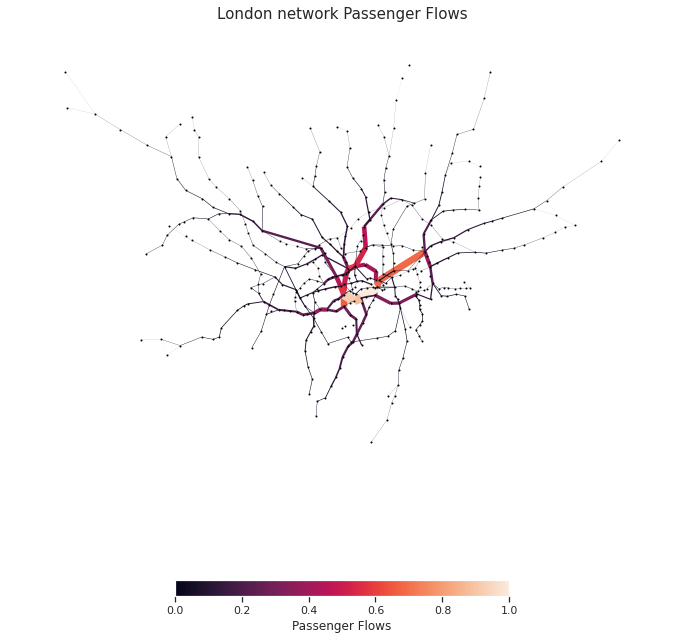

In [156]:
#plot our calcuated flows
flows_values = flows.values()
flow_color=[(i[2]['flows']/max(flows_values)) for i in G.edges(data=True)]
flow_width=[(i[2]['flows']/max(flows_values)*10) for i in G.edges(data=True)]


# Plot graph
fig, ax = plt.subplots(figsize=(12,12))

#pos=nx.spring_layout(X)
edg=nx.draw_networkx_edges(G, pos,edge_color=flow_color, width=flow_width)

nx.draw_networkx_nodes(G,
        pos = pos,
        node_color= 'black',
        node_size= 1)

plt.colorbar(edg,label="Passenger Flows",orientation="horizontal", shrink=0.5)
plt.axis("off")
plt.title("London network Passenger Flows",fontsize=15)
plt.show()

In [157]:
#save graph
for i in G.nodes():
    G.nodes[i]['coords'] = str(G.nodes[i]['coords'])
nx.write_graphml_lxml(G, "outputs/london.graph")

### create OD pairs

In [158]:
#### Create Origin Destination matrix
OD = pd.pivot_table(london_OD_AMpeak, 
                    values ="flows", 
                    index="station_origin", 
                    columns = "station_destination",
                    aggfunc=sum, 
                    margins=True)
OD.fillna(0, inplace=True)
OD = OD.astype(int)
OD.to_csv('outputs/OD_matrix.csv')

In [159]:
OD.sort_values(by='All').tail(10)

station_destination,Abbey Road,Acton Central,Acton Town,Aldgate,Aldgate East,All Saints,Alperton,Amersham,Anerley,Angel,...,Wimbledon,Wimbledon Park,Wood Green,Wood Lane,Wood Street,Woodford,Woodgrange Park,Woodside Park,Woolwich Arsenal,All
station_origin,,,,,,,,,,,,,,,,,,,,,
Finsbury Park,0,0,19,156,39,0,6,1,0,34,...,16,4,113,18,0,0,0,2,0,24735
Canada Water,0,0,17,0,0,0,5,0,43,81,...,0,1,6,2,0,3,0,4,0,27026
King's Cross St. Pancras,0,0,22,842,160,0,7,2,0,135,...,38,8,71,214,0,3,0,12,0,28307
Bank and Monument,0,0,6,31,250,25,0,0,0,518,...,38,2,31,1,0,10,0,9,509,29494
Liverpool Street,0,0,12,384,150,0,3,3,0,121,...,5,1,15,53,61,12,0,1,0,31473
London Bridge,0,0,24,20,47,0,9,1,0,905,...,0,1,52,1,0,5,0,9,0,32597
Victoria,0,0,30,59,153,0,9,2,0,235,...,53,2,122,2,0,7,0,26,0,37517
Stratford,223,25,7,18,186,157,3,0,0,167,...,3,4,43,1,0,133,0,8,1106,59311
Waterloo,0,0,14,108,381,0,6,1,0,306,...,2,0,43,5,0,12,0,18,0,67372


In [160]:
#lets get total at origin and total at destinations
origin = OD.loc[:,'All'].to_dict()
destination = OD.loc['All',:].to_dict()

In [161]:
#lets add this data as population and jobs
london_OD_AMpeak['population'] = london_OD_AMpeak.station_origin.apply(lambda x: origin[x])
london_OD_AMpeak['jobs'] = london_OD_AMpeak.station_destination.apply(lambda x: destination[x])

In [162]:
#get distance between stations withion the network
london_OD_AMpeak['distance'] = -1
for i, row in london_OD_AMpeak.iterrows():
    source = row.station_origin
    target = row.station_destination
    distance = nx.shortest_path_length(G, source, target, weight='length', method='dijkstra')
    london_OD_AMpeak.loc[i, 'distance'] = distance

# or you could use all_pairs_dijkstra_path_length(G, weight='length') to get all distances at once...

In [163]:
london_OD_AMpeak.to_csv('outputs/london_flows.csv', index=False)

## Part 1: London’s underground resilience

### 1. Topological network

you will investigate which are the stations that are most critical for the functioning of the underground, and which methodology is more appropriate to finding these stations.

- Lenght

#### 1.1. Centrality measures:

1. Select 3 centrality measures to characterise nodes
    * 3 centralities measures :  degree centrality, closeness centrality and betweenness centrality
2. Give the definition of each of the measures (including their equation)
    - **Degree Centrality:** The number of links associated to a node 
    - **Eigenvector Centrality:** The influence of a node in a network
    
Cx =
PN
i
[CX(p∗) − Cx(pi)]
max PN
i
[CX(p∗) − Cx(pi)]  
    
 - **Betweenness centrality:** The shortest path passing through a node
    
    The betweenness centrality of a vertex corresponds to the number of shortest paths passing through it among all pairs. Edge betweennness is defined in a similar, where the edge is within the shortest path.

Define $n^{i}_{st}$ as:
    
\begin{equation}
n^{i}_{st}=\begin{cases}
1, & \text{if vertex $i$ lies on the geodesic path from $s$ to $t$}.\\
0, & \text{otherwise}.
  \end{cases}
\end{equation}



Then betweenness centrality can be defined as:
              
\begin{equation}x_{i}=\sum_{st} n^{i}_{st}\end{equation}

However, there may be multiple geodesics from $s$ to $t$ so to account for this we normalise by the number of geodesics from $s$ to $t$, $g_{st}$:

\begin{equation}x_{i}=\sum_{st} \frac {n^{i}_{st}}{g_{st}}\end{equation}


3. Compute the measures for your nodes in the network
4. give the results in a table for the first 10 ranked nodes for each of the 3 measures.



* I need to give the context of each meaning in the tube network

##### Degree Centrality

The number of links associated to a node

In [164]:
#  We can calculate the degree centrality using networkx function:
deg_london =nx.degree_centrality(G)
nx.set_node_attributes(G,dict(deg_london),'degree')

# To dataframe using the nodes as the index
df_dg = pd.DataFrame(index=G.nodes())
#df['station_name'] = pd.Series(nx.get_node_attributes(G, 'station_name'))
df_dg['degree'] = pd.Series(nx.get_node_attributes(G, 'degree'))

df_dg = df_dg.sort_values(["degree"], ascending=False)
df_dg[0:10]

,degree
Stratford,0.0225
Bank and Monument,0.0200
Baker Street,0.0175
King's Cross St. Pancras,0.0175
Waterloo,0.0150
Earl's Court,0.0150
Liverpool Street,0.0150
Oxford Circus,0.0150
Green Park,0.0150
Canning Town,0.0150


In [165]:
df_dg = df_dg.sort_values(["degree"], ascending=False)
df_dg[0:10]

,degree
Stratford,0.0225
Bank and Monument,0.0200
Baker Street,0.0175
King's Cross St. Pancras,0.0175
Waterloo,0.0150
Earl's Court,0.0150
Liverpool Street,0.0150
Oxford Circus,0.0150
Green Park,0.0150
Canning Town,0.0150


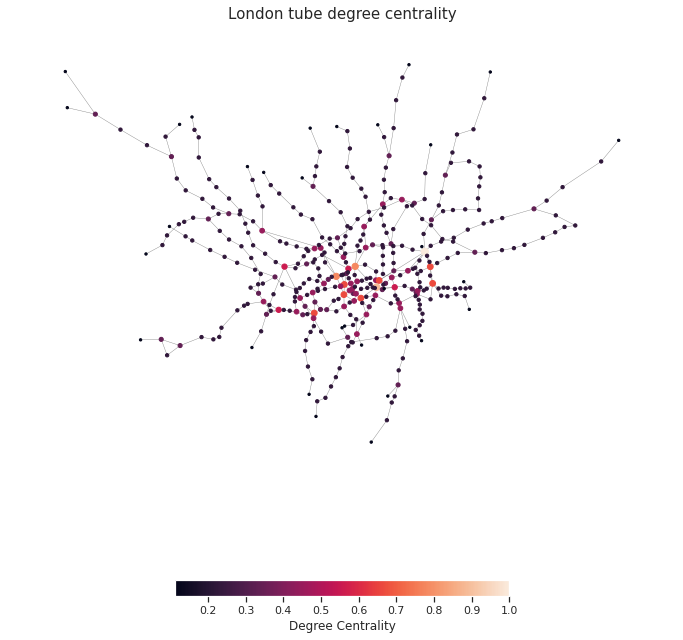

In [198]:
# Lets set colour and size of nodes according to betweenness values
degree_values=[(i[1]['degree']) for i in G.nodes(data=True)]

deg_color=[(i[1]['degree']/(max(degree_values))) for i in G.nodes(data=True)]
deg_size=[(i[1]['degree']/(max(degree_values)))*50 for i in G.nodes(data=True)]



# Plot graph

pos=pos

fig, ax = plt.subplots(figsize=(12,12))


nx.draw_networkx_edges(G, pos,edge_color='gray', 
        width=0.4)
nod=nx.draw_networkx_nodes(G,
        pos = pos,
        node_color= deg_color,
        node_size= deg_size)

plt.colorbar(nod,label="Degree Centrality",orientation="horizontal", shrink=0.5)
plt.axis("off")
plt.title("London tube degree centrality",fontsize=15)
plt.savefig("Image/Part1_topologicalmap_degree", bbox_inches = 'tight')
plt.show()


##### Eigenvector Centrality:

The influence of a node in a network


In [167]:
#Eigenvector closeness centrality: 
eigen =nx.eigenvector_centrality_numpy(G)
# We can add these values to the nodes attributes:
nx.set_node_attributes(G,eigen,'eigen')

# To ataframe using the nodes as the index
df_eg = pd.DataFrame(index=G.nodes())
#df_cl['station_name'] = pd.Series(nx.get_node_attributes(G, 'station_name'))
df_eg['eigen'] = pd.Series(nx.get_node_attributes(G, 'eigen'))

df_eg = df_eg.sort_values(["eigen"], ascending=False)
df_eg[0:10]

,eigen
Bank and Monument,0.383725
Liverpool Street,0.329191
Stratford,0.269574
Waterloo,0.249708
Moorgate,0.215343
Green Park,0.197023
Oxford Circus,0.183441
Tower Hill,0.171839
Westminster,0.168368
Shadwell,0.159233


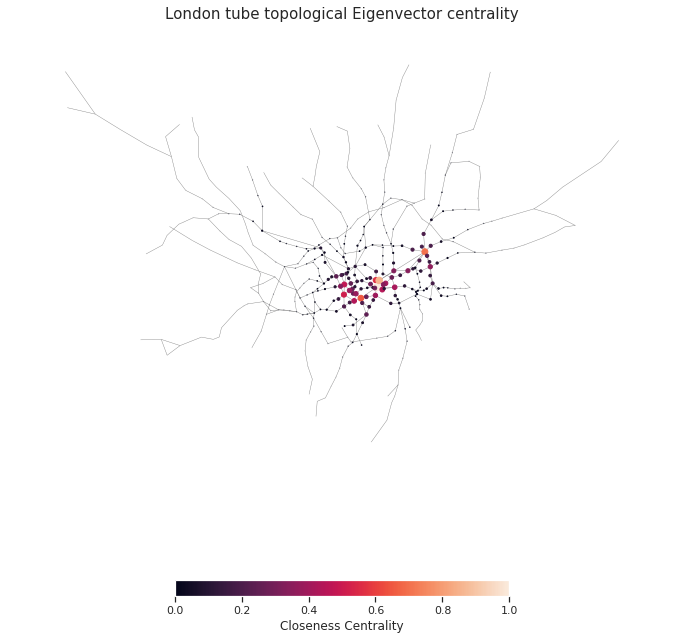

In [199]:
# Lets set color and width of nodes according to the closeness values

clos_w_val=[(i[1]['eigen']) for i in G.nodes(data=True)]

closs_w_color=[(i[1]['eigen']-min(clos_w_val))/(max(clos_w_val)-min(clos_w_val)) for i in G.nodes(data=True)]
closs_w_size=[((i[1]['eigen']-min(clos_w_val))/(max(clos_w_val)-min(clos_w_val))*50) for i in G.nodes(data=True)]

# Plot graph
fig, ax = plt.subplots(figsize=(12,12))

nx.draw_networkx_edges(G, pos,edge_color='gray', 
        width=0.4)

nod=nx.draw_networkx_nodes(G,
        pos = pos,
        node_color= closs_w_color,
        node_size= closs_w_size)

plt.colorbar(nod,label="Closeness Centrality",orientation="horizontal", shrink=0.5)
plt.axis("off")
plt.title("London tube topological Eigenvector centrality",fontsize=15)
plt.savefig("Image/Part1_topologicalmap_eigenvector", bbox_inches = 'tight')
plt.show()


##### Betweenness Centrality

The way of detecting the amount of influence a node has over the flow of information in a graph. It is often used to find nodes that serve as a bridge from one part of a graph to another. The algorithm calculates shortest paths between all pairs of nodes in a graph. It tell us the importance of a node.

In [169]:
### Topological betweenness centrality:

#Let us compute the betweenness centrality for the network, without using weights:
bet_london_t=nx.betweenness_centrality(G)
# We can add these values to the nodes attributes:
nx.set_node_attributes(G,bet_london_t,'betweenness')

# To dataframe using the nodes as the index
df_bt = pd.DataFrame(index=G.nodes())
# df['station_name'] = pd.Series(nx.get_node_attributes(G, 'station_name'))
df_bt['betweenness'] = pd.Series(nx.get_node_attributes(G, 'betweenness'))

df_bt= df_bt.sort_values(["betweenness"], ascending=False)
df_bt[0:10]


,betweenness
Stratford,0.297846
Bank and Monument,0.290489
Liverpool Street,0.270807
King's Cross St. Pancras,0.255307
Waterloo,0.243921
Green Park,0.215835
Euston,0.208324
Westminster,0.203335
Baker Street,0.191568
Finchley Road,0.165085


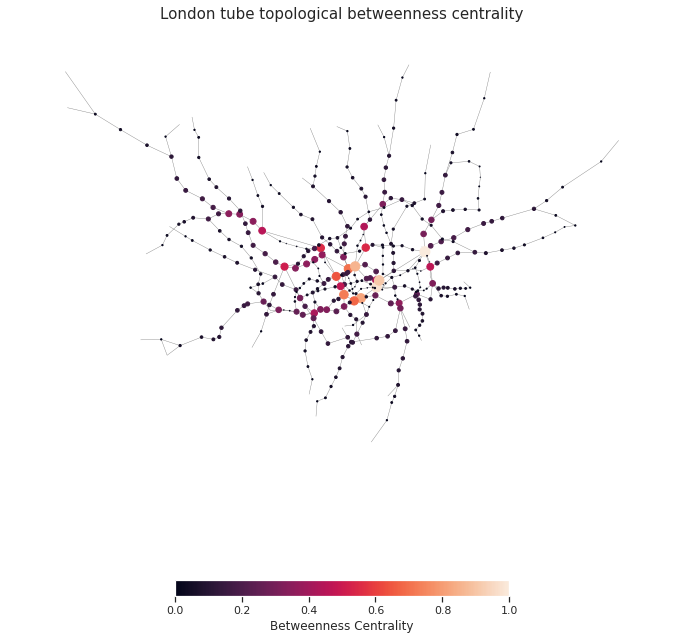

In [200]:
# Lets set colour and size of nodes according to betweenness values
betweenness_t_values=[(i[1]['betweenness']) for i in G.nodes(data=True)]

bet_t_color=[(i[1]['betweenness']/max(betweenness_t_values)) for i in G.nodes(data=True)]
bet_t_size=[(i[1]['betweenness']/max(betweenness_t_values))*100 for i in G.nodes(data=True)]

# Plot graph
fig, ax = plt.subplots(figsize=(12,12))

nx.draw_networkx_edges(G, pos,edge_color='gray', width=0.4)

nod=nx.draw_networkx_nodes(G, pos = pos, node_color= bet_t_color, node_size= bet_t_size)

plt.colorbar(nod,label="Betweenness Centrality",orientation="horizontal", shrink=0.5)
plt.axis("off")
plt.title("London tube topological betweenness centrality",fontsize=15)
plt.savefig("Image/Part1_topologicalmap_betweenness", bbox_inches = 'tight')
plt.show()


##### Summarizing

In [171]:
# Transform the index into a column
df_dg.reset_index(inplace=True)
df_eg.reset_index(inplace=True)
df_bt.reset_index(inplace=True)

# Rename the column 'index' as 'station'
df_dg.rename(columns={'index': 'station_degree'}, inplace=True)
df_eg.rename(columns={'index': 'station_eigenvector'}, inplace=True)
df_bt.rename(columns={'index': 'station_betweness'}, inplace=True)

#merge the datasets
df_centralities = pd.concat([df_dg, df_eg, df_bt], axis=1)

#add rank coloumn
rank = list(range(1, df_centralities.shape[0]+1))
df_centralities.insert(0, 'rank', rank)

df_centralities[0:10]


,rank,station_degree,degree,station_eigenvector,eigen,station_betweness,betweenness
0,1,Stratford,0.0225,Bank and Monument,0.383725,Stratford,0.297846
1,2,Bank and Monument,0.0200,Liverpool Street,0.329191,Bank and Monument,0.290489
2,3,Baker Street,0.0175,Stratford,0.269574,Liverpool Street,0.270807
3,4,King's Cross St. Pancras,0.0175,Waterloo,0.249708,King's Cross St. Pancras,0.255307
4,5,Waterloo,0.0150,Moorgate,0.215343,Waterloo,0.243921
5,6,Earl's Court,0.0150,Green Park,0.197023,Green Park,0.215835
6,7,Liverpool Street,0.0150,Oxford Circus,0.183441,Euston,0.208324
7,8,Oxford Circus,0.0150,Tower Hill,0.171839,Westminster,0.203335
8,9,Green Park,0.0150,Westminster,0.168368,Baker Street,0.191568
9,10,Canning Town,0.0150,Shadwell,0.159233,Finchley Road,0.165085


#### 1.2. Impact measures

- Find 2 different measures
- Evaluate the impact of the node removal on the network
- These need to be global measures referring to the whole network and not to specific nodes or links
- Are they just applicable for London Underground or can be applied for other network?


- Distance and Diameter
- 

Use this references below to explain why I choose this variables and also what is the other applications of this measures in other types of network

**Reference**

Jamakovic, A. and Uhlig, S., 2008. On the relationships between topological measures in real-world networks. Networks Heterog. Media, 3(2), pp.345-359.

Kantarci, B. and Labatut, V., 2013, September. Classification of complex networks based on topological properties. In 2013 international conference on Cloud and Green Computing (pp. 297-304). IEEE.

Lin, J. and Ban, Y., 2013. Complex network topology of transportation systems. Transport reviews, 33(6), pp.658-685.

#### 1.3. Node removal: 
Remove at least 10 nodes



- when you reduce the efficient, so as you remove the nodes, the nodes have to reduce the efficient,

- after remove 1, after remove the seconde one and so on...............( IN THE WHOLE SYSTEM)


###### Non-sequential Removal

- Remove 1 node following the rank
- Evaluate the impact using the **two measures**

Using your table in 1.- remove 1 node at a time following the rank in the table, i.e. from the most important one to the 10th most important one. After each removal, evaluate the impact of the removal using your two measures in 2.-, and proceed until you have removed at least 10 nodes.

###### DEGREE CENTRALITY

In [172]:
#DEGREE CENTRALITY

# create a copy of the graph object
G_copy = G.copy()

#  We can calculate the degree centrality using networkx function:
deg =nx.degree_centrality(G_copy)
nx.set_node_attributes(G_copy,dict(deg),'degree')

# initialize empty lists to store results
num_nodes_removed_list = []
total_component_list = []
size_largestcomponent_list = []
total_nodes_list = []
station_list = []

# loop through values of n from 0 to 10
for n in range(0, 11):
    
    # Number of existing nodes:
    l1=list(G_copy.nodes)
    Number_existing_nodes = len(l1)
    
    # remove n highest node values
    nodes_to_remove = sorted(deg.items(), key=itemgetter(1), reverse=True)
    sorted_one=[e for e,v in nodes_to_remove[:n]]
    G_copy.remove_nodes_from(sorted_one)

    # number of nodes after the removal
    l2=list(G_copy.nodes)
    len(l2)
    # to check name of the station removed:
    rem_node =list(set(l1) - set(l2))
    rem_node
    
    # count the number of nodes removed
    num_nodes_removed = n

    # number of connected components 
    Connected_components = nx.number_connected_components(G_copy)
    
    # To obtain the largest component as a new graph: 
    # Get the list of components:
    components = nx.connected_components(G_copy)
    # Use the max() command to find the largest one:
    largest_component = max(components, key=len)
    # Create a "subgraph" of the largest component
    Largest_subgraph = G_copy.subgraph(largest_component)
    # To compute the size of the largest component:
    size_largestcomponent = Largest_subgraph.number_of_nodes()
    

    # append results to the respective lists
    num_nodes_removed_list.append(num_nodes_removed)
    total_component_list.append(Connected_components)
    size_largestcomponent_list.append(size_largestcomponent)
    total_nodes_list.append(Number_existing_nodes)
    station_list.append(rem_node)    
    
# create a pandas DataFrame and add the information as columns
DC_ns = pd.DataFrame()
DC_ns['Node removed'] = num_nodes_removed_list
DC_ns['Number of Components'] = total_component_list
DC_ns['Size Largest Component'] = size_largestcomponent_list
DC_ns['Total Nodes'] = total_nodes_list
DC_ns['Station'] = station_list


DC_ns

,Node removed,Number of Components,Size Largest Component,Total Nodes,Station
0,0,1,401,401,[]
1,1,3,379,401,[Stratford]
2,2,3,378,400,[Bank and Monument]
3,3,3,377,399,[King's Cross St. Pancras]
4,4,4,374,398,[Baker Street]
5,5,4,373,397,[Waterloo]
6,6,4,372,396,[Green Park]
7,7,5,370,395,[Oxford Circus]
8,8,6,364,394,[Liverpool Street]
9,9,7,361,393,[West Ham]


###### EIGENVECTOR CENTRALITY

In [173]:
#EIGENVECTOR CENTRALITY

# create a copy of the graph object
G_copy = G.copy()

#Eigenvector closeness centrality: 
eigen =nx.eigenvector_centrality_numpy(G_copy)
# We can add these values to the nodes attributes:
nx.set_node_attributes(G_copy,eigen,'eigen')

# initialize empty lists to store results
num_nodes_removed_list = []
total_component_list = []
size_largestcomponent_list = []
total_nodes_list = []
station_list = []


# loop through values of n from 1 to 10
for n in range(0, 11):
     
   # Number of existing nodes:
    l1=list(G_copy.nodes)
    Number_existing_nodes = len(l1)
    
    # remove n highest node values
    nodes_to_remove = sorted(eigen.items(), key=itemgetter(1), reverse=True)
    sorted_one=[e for e,v in nodes_to_remove[:n]]
    G_copy.remove_nodes_from(sorted_one)

    # number of nodes after the removal
    l2=list(G_copy.nodes)
    len(l2)
    # to check name of the station removed:
    rem_node =list(set(l1) - set(l2))
    rem_node
    
    # count the number of nodes removed
    num_nodes_removed = n

    # number of connected components 
    Connected_components = nx.number_connected_components(G_copy)
    
    # To obtain the largest component as a new graph: 
    # Get the list of components:
    components = nx.connected_components(G_copy)
    # Use the max() command to find the largest one:
    largest_component = max(components, key=len)
    # Create a "subgraph" of the largest component
    Largest_subgraph = G_copy.subgraph(largest_component)
    # To compute the size of the largest component:
    size_largestcomponent = Largest_subgraph.number_of_nodes()
    

    # append results to the respective lists
    num_nodes_removed_list.append(num_nodes_removed)
    total_component_list.append(Connected_components)
    size_largestcomponent_list.append(size_largestcomponent)
    total_nodes_list.append(Number_existing_nodes)
    station_list.append(rem_node)  

# create a pandas DataFrame and add the information as columns
EC_ns = pd.DataFrame()
EC_ns['Node removed'] = num_nodes_removed_list
EC_ns['Number of Components'] = total_component_list
EC_ns['Size Largest Component'] = size_largestcomponent_list
EC_ns['Total Nodes'] = total_nodes_list
EC_ns['Station'] = station_list

EC_ns

,Node removed,Number of Components,Size Largest Component,Total Nodes,Station
0,0,1,401,401,[]
1,1,1,400,401,[Bank and Monument]
2,2,1,399,400,[Liverpool Street]
3,3,3,377,399,[Stratford]
4,4,3,376,398,[Waterloo]
5,5,3,375,397,[Moorgate]
6,6,3,374,396,[Green Park]
7,7,3,373,395,[Oxford Circus]
8,8,4,371,394,[Tower Hill]
9,9,4,370,393,[Westminster]


###### BETWENESS CENTRALITY

In [174]:
#BETWENESS CENTRALITY

# create a copy of the graph object
G_copy = G.copy()

#Let us compute the betweenness centrality for the network, without using weights:
bet=nx.betweenness_centrality(G_copy)
nx.set_node_attributes(G_copy,dict(bet),'betweenness')

# initialize empty lists to store results
num_nodes_removed_list = []
total_component_list = []
size_largestcomponent_list = []
total_nodes_list = []
station_list = []


# loop through values of n from 1 to 10
for n in range(0, 11):
     
   # Number of existing nodes:
    l1=list(G_copy.nodes)
    Number_existing_nodes = len(l1)
    
    # remove n highest node values
    nodes_to_remove = sorted(bet.items(), key=itemgetter(1), reverse=True)
    sorted_one=[e for e,v in nodes_to_remove[:n]]
    G_copy.remove_nodes_from(sorted_one)

    # number of nodes after the removal
    l2=list(G_copy.nodes)
    len(l2)
    # to check name of the station removed:
    rem_node =list(set(l1) - set(l2))
    rem_node
    
    # count the number of nodes removed
    num_nodes_removed = n

    # number of connected components 
    Connected_components = nx.number_connected_components(G_copy)
    
    # To obtain the largest component as a new graph: 
    # Get the list of components:
    components = nx.connected_components(G_copy)
    # Use the max() command to find the largest one:
    largest_component = max(components, key=len)
    # Create a "subgraph" of the largest component
    Largest_subgraph = G_copy.subgraph(largest_component)
    # To compute the size of the largest component:
    size_largestcomponent = Largest_subgraph.number_of_nodes()
    

    # append results to the respective lists
    num_nodes_removed_list.append(num_nodes_removed)
    total_component_list.append(Connected_components)
    size_largestcomponent_list.append(size_largestcomponent)
    total_nodes_list.append(Number_existing_nodes)
    station_list.append(rem_node)  

# create a pandas DataFrame and add the information as columns
BC_ns = pd.DataFrame()
BC_ns['Node removed'] = num_nodes_removed_list
BC_ns['Number of Components'] = total_component_list
BC_ns['Size Largest Component'] = size_largestcomponent_list
BC_ns['Total Nodes'] = total_nodes_list
BC_ns['Station'] = station_list

BC_ns


,Node removed,Number of Components,Size Largest Component,Total Nodes,Station
0,0,1,401,401,[]
1,1,3,379,401,[Stratford]
2,2,3,378,400,[Bank and Monument]
3,3,3,377,399,[Liverpool Street]
4,4,4,371,398,[King's Cross St. Pancras]
5,5,4,370,397,[Waterloo]
6,6,4,369,396,[Green Park]
7,7,5,346,395,[Euston]
8,8,5,345,394,[Westminster]
9,9,6,342,393,[Baker Street]


###### SUMMARY

In [175]:
DC_ns = DC_ns.assign(Centrality=pd.Series(['degree']*len(DC_ns)).values)
EC_ns = EC_ns.assign(Centrality=pd.Series(['eigen']*len(EC_ns)).values)
BC_ns = BC_ns.assign(Centrality=pd.Series(['betweeness']*len(BC_ns)).values)

In [176]:
merged_df = pd.concat([DC_ns, EC_ns, BC_ns], ignore_index=True)
merged_df

,Node removed,Number of Components,Size Largest Component,Total Nodes,Station,Centrality
0,0,1,401,401,[],degree
1,1,3,379,401,[Stratford],degree
2,2,3,378,400,[Bank and Monument],degree
3,3,3,377,399,[King's Cross St. Pancras],degree
4,4,4,374,398,[Baker Street],degree
5,5,4,373,397,[Waterloo],degree
6,6,4,372,396,[Green Park],degree
7,7,5,370,395,[Oxford Circus],degree
8,8,6,364,394,[Liverpool Street],degree
9,9,7,361,393,[West Ham],degree


In [177]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33 entries, 0 to 32
Data columns (total 6 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   Node removed            33 non-null     int64 
 1   Number of Components    33 non-null     int64 
 2   Size Largest Component  33 non-null     int64 
 3   Total Nodes             33 non-null     int64 
 4   Station                 33 non-null     object
 5   Centrality              33 non-null     object
dtypes: int64(4), object(2)
memory usage: 1.7+ KB


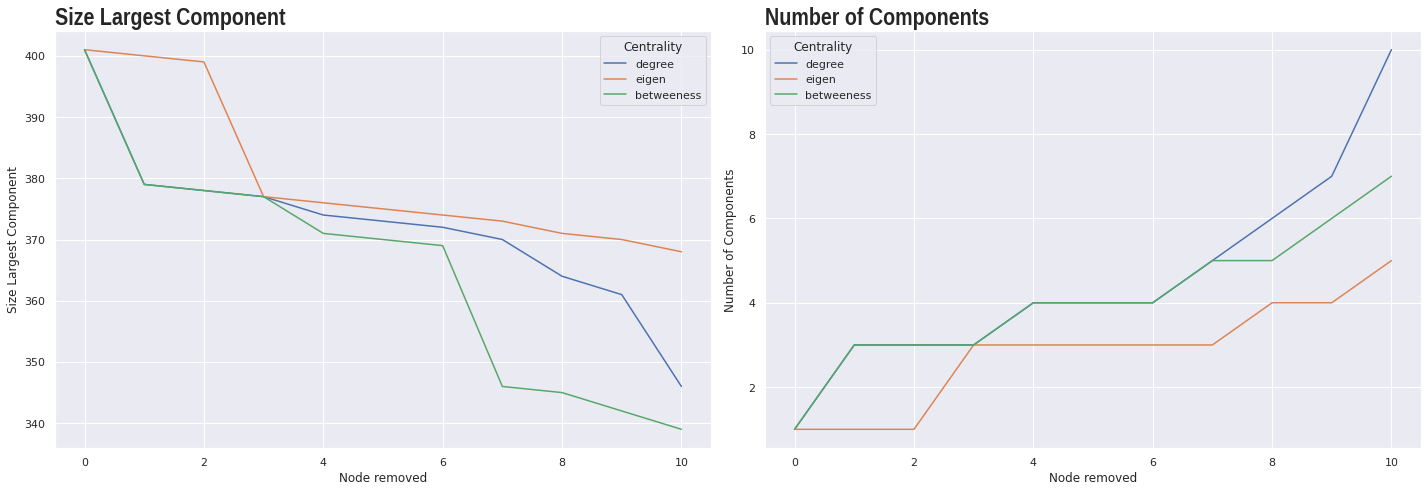

In [178]:
#setup the font
tfont = {'fontname':'Liberation Sans Narrow', 'weight':'bold'}
afont = {'fontname':'Liberation Sans Narrow', 'weight':'light'}

sns.set_theme(style="darkgrid")
fig, [ax1, ax2] = plt.subplots(1, 2, sharey=False, tight_layout=True, figsize=(20,7))

ax1.set_title("Size Largest Component",loc='left',size=24, **tfont)
ax2.set_title("Number of Components",loc='left',size=24, **tfont)

sns.lineplot(data=merged_df, x="Node removed", y="Size Largest Component", hue="Centrality",ax=ax1)
sns.lineplot(data=merged_df, x="Node removed", y="Number of Components", hue="Centrality",ax=ax2)

plt.savefig("Image/Part1_nonsequential_Summarise", bbox_inches = 'tight')

###### Sequential Removal

Remove the highest ranked node and evaluate the impact using the 2 measures. After removal, re-compute the centrality measure. Remove the highest ranked node in the new network and evaluate the impact. Continue until removing at least 10 nodes. Report the results of the 2 strategies in one plot, and critically discuss the following: which centrality measure reflects better the importance of a station for the functioning of the underground, which strategy is more effective at studying resilience, and which impact measure is better at assessing the damage after node removal.

###### DEGREE CENTRALITY

In [179]:
#DEGREE CENTRALITY

# create a copy of the graph object
G_copy = G.copy()

# initialize empty lists to store results
num_nodes_removed_list = []
total_component_list = []
size_largestcomponent_list = []
total_nodes_list = []
station_list = []

###Initial evaluation  
    
#  We can calculate the degree centrality using networkx function:
deg =nx.degree_centrality(G_copy)
nx.set_node_attributes(G_copy,dict(deg),'degree')
    
# remove n highest node values
nodes_to_remove = sorted(deg.items(), key=itemgetter(1), reverse=True)
sorted_one=[e for e,v in nodes_to_remove[:0]]
G_copy.remove_nodes_from(sorted_one)
    
# Number of existing nodes:
l1=list(G_copy.nodes)
Number_existing_nodes = len(l1)

# number of nodes after the removal
l2=list(G_copy.nodes)
len(l2)
 # to check name of the station removed:
rem_node =list(set(l1) - set(l2))
rem_node
    
# count the number of nodes removed
num_nodes_removed = 0

# number of connected components 
Connected_components = nx.number_connected_components(G_copy)
    
# To obtain the largest component as a new graph: 
# Get the list of components:
components = nx.connected_components(G_copy)
# Use the max() command to find the largest one:
largest_component = max(components, key=len)
# Create a "subgraph" of the largest component
Largest_subgraph = G_copy.subgraph(largest_component)
# To compute the size of the largest component:
size_largestcomponent = Largest_subgraph.number_of_nodes()
    

# append results to the respective lists
num_nodes_removed_list.append(num_nodes_removed)
total_component_list.append(Connected_components)
size_largestcomponent_list.append(size_largestcomponent)
total_nodes_list.append(Number_existing_nodes)
station_list.append(rem_node)    

# loop through values of n from 1 to 10
for n in range(1, 11):
  
    #  We can calculate the degree centrality using networkx function:
    deg =nx.degree_centrality(G_copy)
    nx.set_node_attributes(G_copy,dict(deg),'degree')
    
    # Number of existing nodes:
    l1=list(G_copy.nodes)
    Number_existing_nodes = len(l1)
    
    # remove n highest node values
    nodes_to_remove = sorted(deg.items(), key=itemgetter(1), reverse=True)
    sorted_one=[e for e,v in nodes_to_remove[:1]]
    G_copy.remove_nodes_from(sorted_one)

    # number of nodes after the removal
    l2=list(G_copy.nodes)
    len(l2)
    # to check name of the station removed:
    rem_node =list(set(l1) - set(l2))
    rem_node
    
    # count the number of nodes removed
    num_nodes_removed = n

    # number of connected components 
    Connected_components = nx.number_connected_components(G_copy)
    
    # To obtain the largest component as a new graph: 
    # Get the list of components:
    components = nx.connected_components(G_copy)
    # Use the max() command to find the largest one:
    largest_component = max(components, key=len)
    # Create a "subgraph" of the largest component
    Largest_subgraph = G_copy.subgraph(largest_component)
    # To compute the size of the largest component:
    size_largestcomponent = Largest_subgraph.number_of_nodes()
    

    # append results to the respective lists
    num_nodes_removed_list.append(num_nodes_removed)
    total_component_list.append(Connected_components)
    size_largestcomponent_list.append(size_largestcomponent)
    total_nodes_list.append(Number_existing_nodes)
    station_list.append(rem_node)    
    
# create a pandas DataFrame and add the information as columns
DC_s = pd.DataFrame()
DC_s['Node removed'] = num_nodes_removed_list
DC_s['Number of Components'] = total_component_list
DC_s['Size Largest Component'] = size_largestcomponent_list
DC_s['Total Nodes'] = total_nodes_list
DC_s['Station'] = station_list


DC_s

,Node removed,Number of Components,Size Largest Component,Total Nodes,Station
0,0,1,401,401,[]
1,1,3,379,401,[Stratford]
2,2,3,378,400,[Bank and Monument]
3,3,3,377,399,[King's Cross St. Pancras]
4,4,4,374,398,[Baker Street]
5,5,4,373,397,[Green Park]
6,6,6,359,396,[Canning Town]
7,7,6,358,395,[Earl's Court]
8,8,6,357,394,[Waterloo]
9,9,7,355,393,[Oxford Circus]


###### EIGENVECTOR CENTRALITY

In [180]:
#EIGENVECTOR CENTRALITY

# create a copy of the graph object
G_copy = G.copy()

# initialize empty lists to store results
num_nodes_removed_list = []
total_component_list = []
size_largestcomponent_list = []
total_nodes_list = []
station_list = []

###Initial evaluation  
    
#Eigenvector closeness centrality: 
eigen =nx.eigenvector_centrality_numpy(G_copy)
# We can add these values to the nodes attributes:
nx.set_node_attributes(G_copy,eigen,'eigen')
    
# remove n highest node values
nodes_to_remove = sorted(eigen.items(), key=itemgetter(1), reverse=True)
sorted_one=[e for e,v in nodes_to_remove[:0]]
G_copy.remove_nodes_from(sorted_one)
    
# Number of existing nodes:
l1=list(G_copy.nodes)
Number_existing_nodes = len(l1)

# number of nodes after the removal
l2=list(G_copy.nodes)
len(l2)
 # to check name of the station removed:
rem_node =list(set(l1) - set(l2))
rem_node
    
# count the number of nodes removed
num_nodes_removed = 0

# number of connected components 
Connected_components = nx.number_connected_components(G_copy)
    
# To obtain the largest component as a new graph: 
# Get the list of components:
components = nx.connected_components(G_copy)
# Use the max() command to find the largest one:
largest_component = max(components, key=len)
# Create a "subgraph" of the largest component
Largest_subgraph = G_copy.subgraph(largest_component)
# To compute the size of the largest component:
size_largestcomponent = Largest_subgraph.number_of_nodes()
    

# append results to the respective lists
num_nodes_removed_list.append(num_nodes_removed)
total_component_list.append(Connected_components)
size_largestcomponent_list.append(size_largestcomponent)
total_nodes_list.append(Number_existing_nodes)
station_list.append(rem_node)    

# loop through values of n from 1 to 10
for n in range(1, 11):
  
    #Eigenvector closeness centrality: 
    eigen =nx.eigenvector_centrality_numpy(G_copy)
    # We can add these values to the nodes attributes:
    nx.set_node_attributes(G_copy,eigen,'eigen')
    
    # Number of existing nodes:
    l1=list(G_copy.nodes)
    Number_existing_nodes = len(l1)
    
    # remove n highest node values
    nodes_to_remove = sorted(eigen.items(), key=itemgetter(1), reverse=True)
    sorted_one=[e for e,v in nodes_to_remove[:1]]
    G_copy.remove_nodes_from(sorted_one)

    # number of nodes after the removal
    l2=list(G_copy.nodes)
    len(l2)
    # to check name of the station removed:
    rem_node =list(set(l1) - set(l2))
    rem_node
    
    # count the number of nodes removed
    num_nodes_removed = n

    # number of connected components 
    Connected_components = nx.number_connected_components(G_copy)
    
    # To obtain the largest component as a new graph: 
    # Get the list of components:
    components = nx.connected_components(G_copy)
    # Use the max() command to find the largest one:
    largest_component = max(components, key=len)
    # Create a "subgraph" of the largest component
    Largest_subgraph = G_copy.subgraph(largest_component)
    # To compute the size of the largest component:
    size_largestcomponent = Largest_subgraph.number_of_nodes()
    

    # append results to the respective lists
    num_nodes_removed_list.append(num_nodes_removed)
    total_component_list.append(Connected_components)
    size_largestcomponent_list.append(size_largestcomponent)
    total_nodes_list.append(Number_existing_nodes)
    station_list.append(rem_node)    
    
# create a pandas DataFrame and add the information as columns
EC_s = pd.DataFrame()
EC_s['Node removed'] = num_nodes_removed_list
EC_s['Number of Components'] = total_component_list
EC_s['Size Largest Component'] = size_largestcomponent_list
EC_s['Total Nodes'] = total_nodes_list
EC_s['Station'] = station_list


EC_s


,Node removed,Number of Components,Size Largest Component,Total Nodes,Station
0,0,1,401,401,[]
1,1,1,400,401,[Bank and Monument]
2,2,1,399,400,[Oxford Circus]
3,3,3,377,399,[Stratford]
4,4,3,376,398,[Earl's Court]
5,5,3,375,397,[Westminster]
6,6,4,373,396,[Baker Street]
7,7,5,370,395,[King's Cross St. Pancras]
8,8,7,356,394,[Canning Town]
9,9,7,355,393,[Turnham Green]


###### BETWENESS CENTRALITY

In [181]:
#BETWENESS CENTRALITY

# create a copy of the graph object
G_copy = G.copy()

# initialize empty lists to store results
num_nodes_removed_list = []
total_component_list = []
size_largestcomponent_list = []
total_nodes_list = []
station_list = []

###Initial evaluation  
    
#Let us compute the betweenness centrality for the network, without using weights:
bet=nx.betweenness_centrality(G_copy)
nx.set_node_attributes(G_copy,dict(bet),'betweenness')
    
# remove n highest node values
nodes_to_remove = sorted(bet.items(), key=itemgetter(1), reverse=True)
sorted_one=[e for e,v in nodes_to_remove[:0]]
G_copy.remove_nodes_from(sorted_one)
    
# Number of existing nodes:
l1=list(G_copy.nodes)
Number_existing_nodes = len(l1)

# number of nodes after the removal
l2=list(G_copy.nodes)
len(l2)
 # to check name of the station removed:
rem_node =list(set(l1) - set(l2))
rem_node
    
# count the number of nodes removed
num_nodes_removed = 0

# number of connected components 
Connected_components = nx.number_connected_components(G_copy)
    
# To obtain the largest component as a new graph: 
# Get the list of components:
components = nx.connected_components(G_copy)
# Use the max() command to find the largest one:
largest_component = max(components, key=len)
# Create a "subgraph" of the largest component
Largest_subgraph = G_copy.subgraph(largest_component)
# To compute the size of the largest component:
size_largestcomponent = Largest_subgraph.number_of_nodes()
    

# append results to the respective lists
num_nodes_removed_list.append(num_nodes_removed)
total_component_list.append(Connected_components)
size_largestcomponent_list.append(size_largestcomponent)
total_nodes_list.append(Number_existing_nodes)
station_list.append(rem_node)    

# loop through values of n from 1 to 10
for n in range(1, 11):
  
    #Let us compute the betweenness centrality for the network, without using weights:
    bet=nx.betweenness_centrality(G_copy)
    nx.set_node_attributes(G_copy,dict(bet),'betweenness')
    
    # Number of existing nodes:
    l1=list(G_copy.nodes)
    Number_existing_nodes = len(l1)
    
    # remove n highest node values
    nodes_to_remove = sorted(bet.items(), key=itemgetter(1), reverse=True)
    sorted_one=[e for e,v in nodes_to_remove[:1]]
    G_copy.remove_nodes_from(sorted_one)

    # number of nodes after the removal
    l2=list(G_copy.nodes)
    len(l2)
    # to check name of the station removed:
    rem_node =list(set(l1) - set(l2))
    rem_node
    
    # count the number of nodes removed
    num_nodes_removed = n

    # number of connected components 
    Connected_components = nx.number_connected_components(G_copy)
    
    # To obtain the largest component as a new graph: 
    # Get the list of components:
    components = nx.connected_components(G_copy)
    # Use the max() command to find the largest one:
    largest_component = max(components, key=len)
    # Create a "subgraph" of the largest component
    Largest_subgraph = G_copy.subgraph(largest_component)
    # To compute the size of the largest component:
    size_largestcomponent = Largest_subgraph.number_of_nodes()
    

    # append results to the respective lists
    num_nodes_removed_list.append(num_nodes_removed)
    total_component_list.append(Connected_components)
    size_largestcomponent_list.append(size_largestcomponent)
    total_nodes_list.append(Number_existing_nodes)
    station_list.append(rem_node)    
    
# create a pandas DataFrame and add the information as columns
BC_s = pd.DataFrame()
BC_s['Node removed'] = num_nodes_removed_list
BC_s['Number of Components'] = total_component_list
BC_s['Size Largest Component'] = size_largestcomponent_list
BC_s['Total Nodes'] = total_nodes_list
BC_s['Station'] = station_list


BC_s

,Node removed,Number of Components,Size Largest Component,Total Nodes,Station
0,0,1,401,401,[]
1,1,3,379,401,[Stratford]
2,2,3,378,400,[King's Cross St. Pancras]
3,3,3,377,399,[Waterloo]
4,4,3,376,398,[Bank and Monument]
5,5,3,375,397,[Canada Water]
6,6,4,227,396,[West Hampstead]
7,7,4,226,395,[Earl's Court]
8,8,5,196,394,[Shepherd's Bush]
9,9,6,173,393,[Euston]


###### SUMMARY

In [182]:
DC_s = DC_s.assign(Centrality=pd.Series(['Degree']*len(DC_s)).values)
EC_s = EC_s.assign(Centrality=pd.Series(['Eigenvector']*len(EC_s)).values)
BC_s = BC_s.assign(Centrality=pd.Series(['Betweeness']*len(BC_s)).values)

In [183]:
merged_df = pd.concat([DC_s, EC_s, BC_s], ignore_index=True)
merged_df

,Node removed,Number of Components,Size Largest Component,Total Nodes,Station,Centrality
0,0,1,401,401,[],Degree
1,1,3,379,401,[Stratford],Degree
2,2,3,378,400,[Bank and Monument],Degree
3,3,3,377,399,[King's Cross St. Pancras],Degree
4,4,4,374,398,[Baker Street],Degree
5,5,4,373,397,[Green Park],Degree
6,6,6,359,396,[Canning Town],Degree
7,7,6,358,395,[Earl's Court],Degree
8,8,6,357,394,[Waterloo],Degree
9,9,7,355,393,[Oxford Circus],Degree


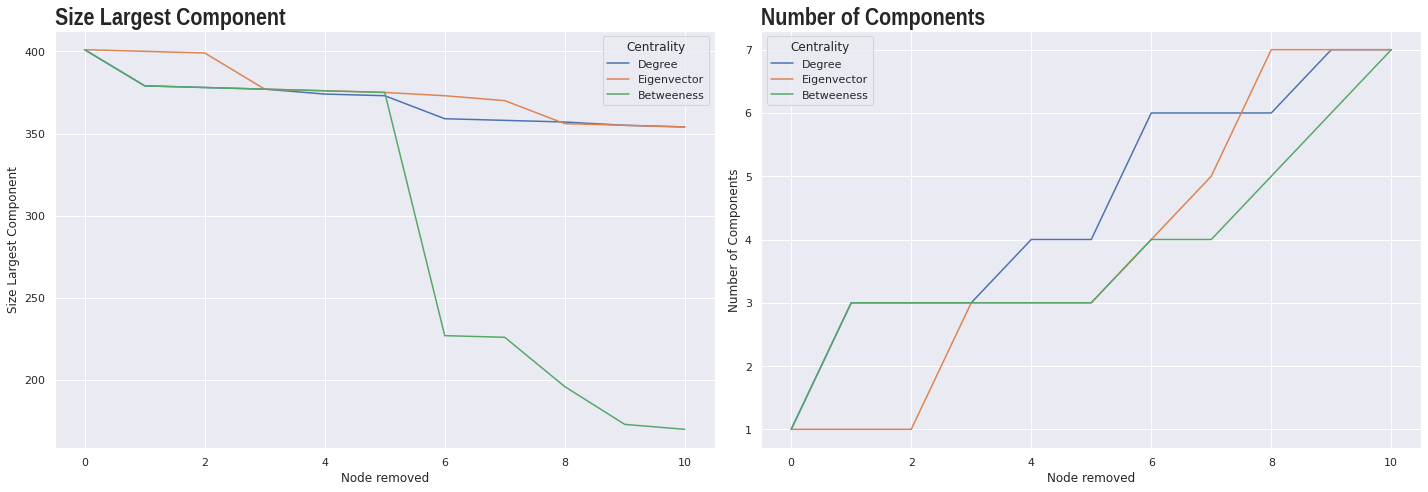

In [184]:
#plot
sns.set_theme(style="darkgrid")
fig, [ax1, ax2] = plt.subplots(1, 2, sharey=False, tight_layout=True, figsize=(20,7))

ax1.set_title("Size Largest Component",loc='left',size=24, **tfont)
ax2.set_title("Number of Components",loc='left',size=24, **tfont)

sns.lineplot(data=merged_df, x="Node removed", y="Size Largest Component", hue="Centrality",ax=ax1)
sns.lineplot(data=merged_df, x="Node removed", y="Number of Components", hue="Centrality",ax=ax2)

plt.savefig("Image/Part1_sequential_Summarise", bbox_inches = 'tight')

the closeness is not reflecting the impact of node removal

### 2.Flows: weighted network

In this section, you will include passengers into the underground, and assess whether different
measures need to be used when flows are considered. The network to use in this section is the
weighted network given to you in the coursework, where the flows of passengers were assigned to the
links between stations.

#### 2.1 Centrality measure

Consider the centrality measure derived in I.- indicating the most relevant stations for assessing
the vulnerability of the underground. What would you need to do to adjust this measure for a
weighted network? Recompute the ranking of the 10 most important nodes according to this adjusted
measure. Do you find the same ones as in I.1?

In [185]:
#  We can calculate the degree centrality using networkx function:
deg_london =nx.degree_centrality(G)
nx.set_node_attributes(G,dict(deg_london),'degree')

# To dataframe using the nodes as the index
dg_w = pd.DataFrame(index=G.nodes())
dg_w['degree'] = pd.Series(nx.get_node_attributes(G, 'degree'))

dg_w = dg_w.sort_values(["degree"], ascending=False)
dg_w[0:10]

,degree
Stratford,0.0225
Bank and Monument,0.0200
Baker Street,0.0175
King's Cross St. Pancras,0.0175
Waterloo,0.0150
Earl's Court,0.0150
Liverpool Street,0.0150
Oxford Circus,0.0150
Green Park,0.0150
Canning Town,0.0150


In [186]:
# To check node attributes:
list(G.edges(data = True))[0]

('Edgware',
 'Burnt Oak',
 {'length': 1518.129678863644, 'line_name': 'Northern', 'flows': 4177})

In [187]:
#Eigenvector closeness centrality: 
eigen =nx.eigenvector_centrality_numpy(G)
# We can add these values to the nodes attributes:
nx.set_node_attributes(G,eigen,'eigen')

# To ataframe using the nodes as the index
eg_w = pd.DataFrame(index=G.nodes())
eg_w['eigen'] = pd.Series(nx.get_node_attributes(G, 'eigen'))

eg_w = eg_w.sort_values(["eigen"], ascending=False)
eg_w[0:10]

,eigen
Bank and Monument,0.383725
Liverpool Street,0.329191
Stratford,0.269574
Waterloo,0.249708
Moorgate,0.215343
Green Park,0.197023
Oxford Circus,0.183441
Tower Hill,0.171839
Westminster,0.168368
Shadwell,0.159233


In [188]:
### Weighted betweenness centrality:
#Let us compute the betweenness centrality for the network, considering the distance between stations:

bet_london_w=nx.betweenness_centrality(G,weight='flows')

# We can add these values to the nodes attributes:
nx.set_node_attributes(G,bet_london_w,'betweenness_w')

# To dataframe using the nodes as the index
bt_w = pd.DataFrame(index=G.nodes())
bt_w['betweenness_w'] = pd.Series(nx.get_node_attributes(G, 'betweenness_w'))

bt_w = bt_w.sort_values(["betweenness_w"], ascending=False)
bt_w[0:10]

,betweenness_w
West Hampstead,0.367857
Gospel Oak,0.297428
Finchley Road & Frognal,0.288036
Hampstead Heath,0.287105
Willesden Junction,0.261078
Stratford,0.259261
Brondesbury,0.236494
Brondesbury Park,0.235056
Kensal Rise,0.233628
Turnham Green,0.175182


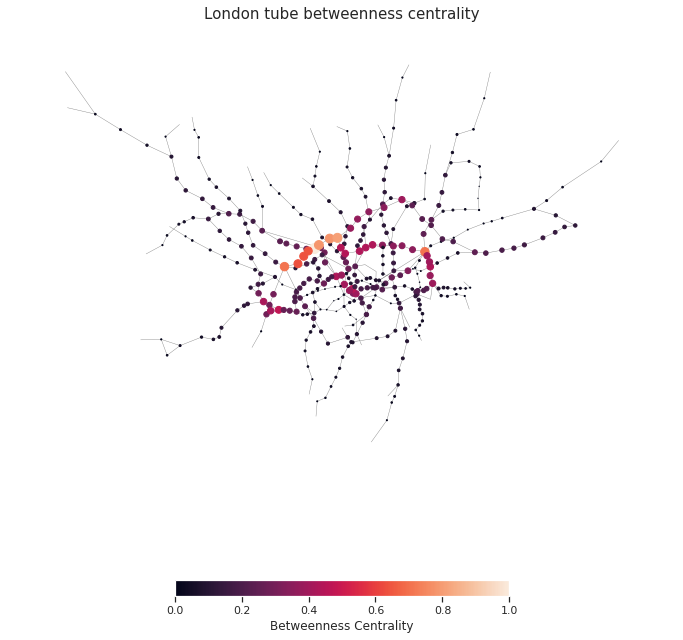

In [189]:
# Lets set colour and size of nodes according to betweenness values
betweenness_w_values=[(i[1]['betweenness_w']) for i in G.nodes(data=True)]

bet_w_color=[(i[1]['betweenness_w']/max(betweenness_w_values)) for i in G.nodes(data=True)]
bet_w_size=[(i[1]['betweenness_w']/max(betweenness_w_values))*100 for i in G.nodes(data=True)]


# Plot graph

pos=pos

fig, ax = plt.subplots(figsize=(12,12))


nx.draw_networkx_edges(G, pos,edge_color='gray', 
        width=0.4)
nod=nx.draw_networkx_nodes(G,
        pos = pos,
        node_color= bet_w_color,
        node_size= bet_w_size)

plt.colorbar(nod,label="Betweenness Centrality",orientation="horizontal", shrink=0.5)
plt.axis("off")
plt.title("London tube betweenness centrality",fontsize=15)
plt.show()

In [190]:
# TO SUMMARISE

# Transform the index into a column
dg_w.reset_index(inplace=True)
eg_w.reset_index(inplace=True)
bt_w.reset_index(inplace=True)

# Rename the column 'index' as 'station'
dg_w.rename(columns={'index': 'station_degree'}, inplace=True)
eg_w.rename(columns={'index': 'station_eigenvector'}, inplace=True)
bt_w.rename(columns={'index': 'station_betweness'}, inplace=True)

#merge the datasets
centralities_w = pd.concat([dg_w, eg_w, bt_w], axis=1)

#add rank coloumn
rank = list(range(1, centralities_w.shape[0]+1))
centralities_w.insert(0, 'rank', rank)

centralities_w[0:10]

,rank,station_degree,degree,station_eigenvector,eigen,station_betweness,betweenness_w
0,1,Stratford,0.0225,Bank and Monument,0.383725,West Hampstead,0.367857
1,2,Bank and Monument,0.0200,Liverpool Street,0.329191,Gospel Oak,0.297428
2,3,Baker Street,0.0175,Stratford,0.269574,Finchley Road & Frognal,0.288036
3,4,King's Cross St. Pancras,0.0175,Waterloo,0.249708,Hampstead Heath,0.287105
4,5,Waterloo,0.0150,Moorgate,0.215343,Willesden Junction,0.261078
5,6,Earl's Court,0.0150,Green Park,0.197023,Stratford,0.259261
6,7,Liverpool Street,0.0150,Oxford Circus,0.183441,Brondesbury,0.236494
7,8,Oxford Circus,0.0150,Tower Hill,0.171839,Brondesbury Park,0.235056
8,9,Green Park,0.0150,Westminster,0.168368,Kensal Rise,0.233628
9,10,Canning Town,0.0150,Shadwell,0.159233,Turnham Green,0.175182


#### 2.2 Impact Measures

Now consider the measure for assessing the impact of node removal. Would you adjust the
measure for a weighted network? If yes, how? Propose a different measure that would be better at
assessing the impact of closing a station taking into consideration the passengers.

- different measures:  diameter(considering the flows betweeen stations and

In [191]:
# Total flows of Largest connected component          
Largest_subgraph = G.subgraph(largest_component)
size_lar_com = Largest_subgraph.number_of_nodes()
flows_connectedcomponent=sum({flows for e1, e2, flows in Largest_subgraph.edges(data='flows')})


#### 2.3 Node Removal:

Remove only the 3 highest ranked nodes according to the best performing centrality measure
found in I.1. Evaluate the impact according to the 2 measures in II.2. Repeat the experiment for the
highest 3 ranked nodes using the adjusted measure. Critically discuss which station closure will have
the largest impact on passengers, referring to your measures and results.

In [192]:
#DEGREE CENTRALITY

# create a copy of the graph object
G_w = G.copy()

#  We can calculate the degree centrality using networkx function:
deg =nx.degree_centrality(G_w)
nx.set_node_attributes(G_w,dict(deg),'degree')

# initialize empty lists to store results
num_nodes_removed_list = []
total_component_list = []
size_largestcomponent_list = []
flows_connectedcomponentlist = []
total_nodes_list = []
station_list = []

# loop through values of n from 0 to 3
for n in range(0, 4):
    
    # Number of existing nodes:
    l1=list(G_w.nodes)
    Number_existing_nodes = len(l1)
    
    # remove n highest node values
    nodes_to_remove = sorted(deg.items(), key=itemgetter(1), reverse=True)
    sorted_one=[e for e,v in nodes_to_remove[:n]]
    G_w.remove_nodes_from(sorted_one)

    # number of nodes after the removal
    l2=list(G_w.nodes)
    len(l2)
    # to check name of the station removed:
    rem_node =list(set(l1) - set(l2))
    rem_node
    
    # count the number of nodes removed
    num_nodes_removed = n

    # number of connected components 
    Connected_components = nx.number_connected_components(G_w)
    
    # To obtain the largest component as a new graph: 
    # Get the list of components:
    components = nx.connected_components(G_w)
    # Use the max() command to find the largest one:
    largest_component = max(components, key=len)
    # Create a "subgraph" of the largest component
    Largest_subgraph = G_w.subgraph(largest_component)
    # To compute the size of the largest component:
    size_largestcomponent = Largest_subgraph.number_of_nodes()
    
    # Total flows of Largest connected component          
    Largest_subgraph = G_w.subgraph(largest_component)
    size_lar_com = Largest_subgraph.number_of_nodes()
    flows_connectedcomponent=sum({flows for e1, e2, flows in Largest_subgraph.edges(data='flows')})
    

    # append results to the respective lists
    num_nodes_removed_list.append(num_nodes_removed)
    total_component_list.append(Connected_components)
    size_largestcomponent_list.append(size_largestcomponent)
    flows_connectedcomponentlist.append(flows_connectedcomponent)
    total_nodes_list.append(Number_existing_nodes)
    station_list.append(rem_node)    
    
# create a pandas DataFrame and add the information as columns
DC = pd.DataFrame()
DC['Node removed'] = num_nodes_removed_list
DC['Number of Components'] = total_component_list
DC['Size Largest Component'] = size_largestcomponent_list
DC['Flows Largest Component'] = flows_connectedcomponentlist
DC['Total Nodes'] = total_nodes_list
DC['Station'] = station_list


DC

,Node removed,Number of Components,Size Largest Component,Flows Largest Component,Total Nodes,Station
0,0,1,401,9830695,401,[]
1,1,3,379,9274809,401,[Stratford]
2,2,3,378,8605744,400,[Bank and Monument]
3,3,3,377,8140045,399,[King's Cross St. Pancras]


###### EIGENVECTOR CENTRALITY

In [193]:
#EIGENVECTOR CENTRALITY

# create a copy of the graph object
G_w = G.copy()

#Eigenvector closeness centrality: 
eigen =nx.eigenvector_centrality_numpy(G_w)
# We can add these values to the nodes attributes:
nx.set_node_attributes(G_w,eigen,'eigen')

# initialize empty lists to store results
num_nodes_removed_list = []
total_component_list = []
size_largestcomponent_list = []
flows_connectedcomponentlist = []
total_nodes_list = []
station_list = []

# loop through values of n from 0 to 3
for n in range(0, 4):
    
    # Number of existing nodes:
    l1=list(G_w.nodes)
    Number_existing_nodes = len(l1)
    
    # remove n highest node values
    nodes_to_remove = sorted(eigen.items(), key=itemgetter(1), reverse=True)
    sorted_one=[e for e,v in nodes_to_remove[:n]]
    G_w.remove_nodes_from(sorted_one)

    # number of nodes after the removal
    l2=list(G_w.nodes)
    len(l2)
    # to check name of the station removed:
    rem_node =list(set(l1) - set(l2))
    rem_node
    
    # count the number of nodes removed
    num_nodes_removed = n

    # number of connected components 
    Connected_components = nx.number_connected_components(G_w)
    
    # To obtain the largest component as a new graph: 
    # Get the list of components:
    components = nx.connected_components(G_w)
    # Use the max() command to find the largest one:
    largest_component = max(components, key=len)
    # Create a "subgraph" of the largest component
    Largest_subgraph = G_w.subgraph(largest_component)
    # To compute the size of the largest component:
    size_largestcomponent = Largest_subgraph.number_of_nodes()
    
    # Total flows of Largest connected component          
    Largest_subgraph = G_w.subgraph(largest_component)
    size_lar_com = Largest_subgraph.number_of_nodes()
    flows_connectedcomponent=sum({flows for e1, e2, flows in Largest_subgraph.edges(data='flows')})
    

    # append results to the respective lists
    num_nodes_removed_list.append(num_nodes_removed)
    total_component_list.append(Connected_components)
    size_largestcomponent_list.append(size_largestcomponent)
    flows_connectedcomponentlist.append(flows_connectedcomponent)
    total_nodes_list.append(Number_existing_nodes)
    station_list.append(rem_node)    
    
# create a pandas DataFrame and add the information as columns
EC = pd.DataFrame()
EC['Node removed'] = num_nodes_removed_list
EC['Number of Components'] = total_component_list
EC['Size Largest Component'] = size_largestcomponent_list
EC['Flows Largest Component'] = flows_connectedcomponentlist
EC['Total Nodes'] = total_nodes_list
EC['Station'] = station_list


EC

,Node removed,Number of Components,Size Largest Component,Flows Largest Component,Total Nodes,Station
0,0,1,401,9830695,401,[]
1,1,1,400,9161630,401,[Bank and Monument]
2,2,1,399,8887734,400,[Liverpool Street]
3,3,3,377,8496352,399,[Stratford]


###### BETWENESS CENTRALITY

In [194]:
#BETWENESS CENTRALITY

# create a copy of the graph object
G_w = G.copy()

#Let us compute the betweenness centrality for the network, without using weights:
bet=nx.betweenness_centrality(G_w)
nx.set_node_attributes(G_w,dict(bet),'betweenness')

# initialize empty lists to store results
num_nodes_removed_list = []
total_component_list = []
size_largestcomponent_list = []
flows_connectedcomponentlist = []
total_nodes_list = []
station_list = []

# loop through values of n from 0 to 3
for n in range(0, 4):
    
    # Number of existing nodes:
    l1=list(G_w.nodes)
    Number_existing_nodes = len(l1)
    
    # remove n highest node values
    nodes_to_remove = sorted(bet.items(), key=itemgetter(1), reverse=True)
    sorted_one=[e for e,v in nodes_to_remove[:n]]
    G_w.remove_nodes_from(sorted_one)

    # number of nodes after the removal
    l2=list(G_w.nodes)
    len(l2)
    # to check name of the station removed:
    rem_node =list(set(l1) - set(l2))
    rem_node
    
    # count the number of nodes removed
    num_nodes_removed = n

    # number of connected components 
    Connected_components = nx.number_connected_components(G_w)
    
    # To obtain the largest component as a new graph: 
    # Get the list of components:
    components = nx.connected_components(G_w)
    # Use the max() command to find the largest one:
    largest_component = max(components, key=len)
    # Create a "subgraph" of the largest component
    Largest_subgraph = G_w.subgraph(largest_component)
    # To compute the size of the largest component:
    size_largestcomponent = Largest_subgraph.number_of_nodes()
    
    # Total flows of Largest connected component          
    Largest_subgraph = G_w.subgraph(largest_component)
    size_lar_com = Largest_subgraph.number_of_nodes()
    flows_connectedcomponent=sum({flows for e1, e2, flows in Largest_subgraph.edges(data='flows')})
    

    # append results to the respective lists
    num_nodes_removed_list.append(num_nodes_removed)
    total_component_list.append(Connected_components)
    size_largestcomponent_list.append(size_largestcomponent)
    flows_connectedcomponentlist.append(flows_connectedcomponent)
    total_nodes_list.append(Number_existing_nodes)
    station_list.append(rem_node)    
    
# create a pandas DataFrame and add the information as columns
BC = pd.DataFrame()
BC['Node removed'] = num_nodes_removed_list
BC['Number of Components'] = total_component_list
BC['Size Largest Component'] = size_largestcomponent_list
BC['Flows Largest Component'] = flows_connectedcomponentlist
BC['Total Nodes'] = total_nodes_list
BC['Station'] = station_list


BC 

,Node removed,Number of Components,Size Largest Component,Flows Largest Component,Total Nodes,Station
0,0,1,401,9830695,401,[]
1,1,3,379,9274809,401,[Stratford]
2,2,3,378,8605744,400,[Bank and Monument]
3,3,3,377,8496352,399,[Liverpool Street]


###### SUMMARY

In [195]:
DC = DC.assign(Centrality=pd.Series(['degree']*len(DC)).values)
EC = EC.assign(Centrality=pd.Series(['eigen']*len(EC)).values)
BC = BC.assign(Centrality=pd.Series(['betweeness']*len(BC)).values)

In [196]:
merged_dfw = pd.concat([DC, EC, BC], ignore_index=True)
merged_dfw

,Node removed,Number of Components,Size Largest Component,Flows Largest Component,Total Nodes,Station,Centrality
0,0,1,401,9830695,401,[],degree
1,1,3,379,9274809,401,[Stratford],degree
2,2,3,378,8605744,400,[Bank and Monument],degree
3,3,3,377,8140045,399,[King's Cross St. Pancras],degree
4,0,1,401,9830695,401,[],eigen
5,1,1,400,9161630,401,[Bank and Monument],eigen
6,2,1,399,8887734,400,[Liverpool Street],eigen
7,3,3,377,8496352,399,[Stratford],eigen
8,0,1,401,9830695,401,[],betweeness
9,1,3,379,9274809,401,[Stratford],betweeness


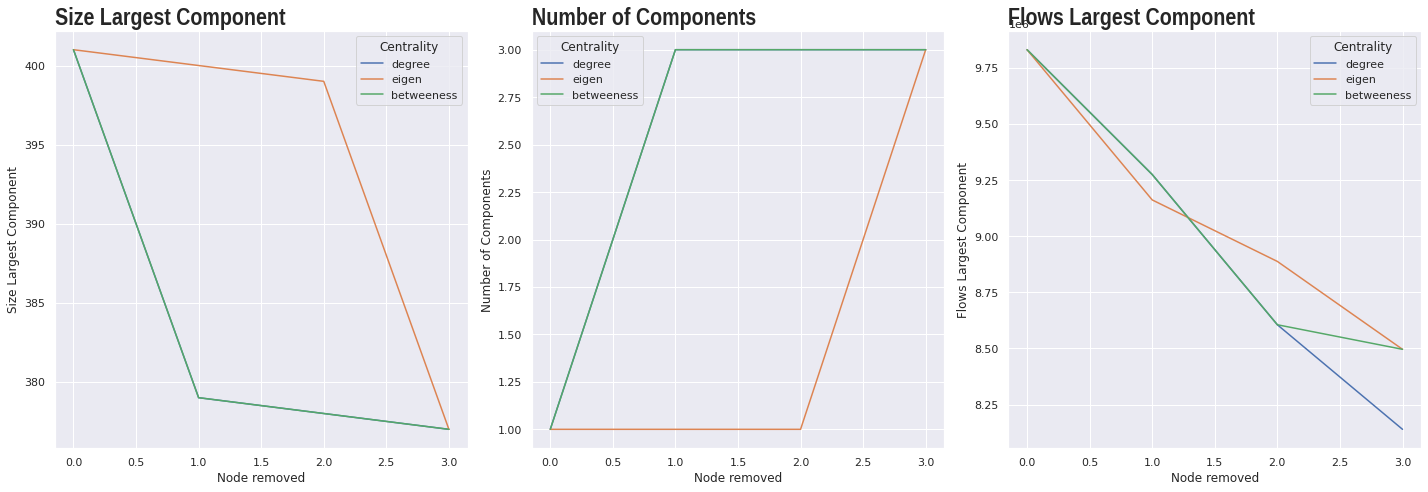

In [197]:
#setup the font
tfont = {'fontname':'Liberation Sans Narrow', 'weight':'bold'}
afont = {'fontname':'Liberation Sans Narrow', 'weight':'light'}

sns.set_theme(style="darkgrid")
fig, [ax1, ax2, ax3] = plt.subplots(1, 3, sharey=False, tight_layout=True, figsize=(20,7))

ax1.set_title("Size Largest Component",loc='left',size=24, **tfont)
ax2.set_title("Number of Components",loc='left',size=24, **tfont)
ax3.set_title("Flows Largest Component",loc='left',size=24, **tfont)

sns.lineplot(data=merged_dfw, x="Node removed", y="Size Largest Component", hue="Centrality",ax= ax1)
sns.lineplot(data=merged_dfw, x="Node removed", y="Number of Components", hue="Centrality",ax= ax2)
sns.lineplot(data=merged_dfw, x="Node removed", y="Flows Largest Component", hue="Centrality",ax= ax3)

plt.savefig("Image/Part2_Summarise", bbox_inches = 'tight')

## Part 2: Spatial Interaction models

For this section, you will be given a “symbolic” population and the number of jobs for the stations in
the underground. You will also be given the number of people that commute from one station to
another, through an OD matrix.

### 3. Models and calibration

#### 3.1 Introduction (Done*)

III.1. Briefly introduce the spatial interaction models covered in the lectures using equations and
defining the terms, taking particular care in explaining the role of the parameters.

##### Gravity Model(unsconstrained model)

\begin{equation} \tag{2}
T_{ij} = k O_i^\alpha  D_j^\gamma  d_{ij}^{-\beta}
\end{equation}

This model just says that the flows between an origin and destination are proportional to the product of the mass of the origin and destination and inversley proportional to the distance between them.

As origin and destination masses increase, flows increase, but as distance increases, flows decrease, and vice versa.</b>

- Where $T_{ij}$ is the transition or flow, $T$, between origin $i$ (always the rows in a matrix) and destination $j$ (always the columns in a matrix). If you are not overly familiar with matrix notation, the i and j are just generic indexes to allow us to refer to any cell in the matrix more generally.
- $O$ is a vector (a 1 dimensional matrix - or, if you like, a single line of numbers) of origin attributes which relate to the emissiveness of all origins in the dataset, $i$ - in our sample dataset, we have a vector of origin populations (which I have called Oi1_origpop) and a vector of origin average salaries (which I have called Oi2_origsal) in 2001
- $D$ is a vector of desination of attributes relating to the attractivenss of all destinations in the dataset, $j$ - in our sample dataset, we have a vector of destination populations (which I have called Dj1_destpop) and a vector of destination average salaries (which I have called Dj2_destsal) in 2001
- $d$ is a matrix of costs relating to the flows between $i$ and $j$ - in our case the cost is the distance and it is called ‘dist’ in our dataset

##### The Poisson Regression Spatial Interaction Model (unsconstrained model) - calibration

\begin{equation} \tag{6}
\lambda_{ij} = \exp (K + \alpha \ln O_i + \gamma \ln D_j - \beta \ln d_{ij})
\end{equation}

What this model says is that $\lambda_{ij}$ (our independent variable - the estimate of $T_{ij}$) is <i>logarithmically linked </i> to (or modelled by) a linear combination of the logged independent variables in the model. 

Now we have Equation 6 at our disposal, we can use a Poisson regression model to produce estimated of $k$, $\alpha$, $\gamma$ and $\beta$ - or put another way, we can use the rgeression model to calibrate our parameters.


##### Production-constrained Model (Constrained Models)



\begin{equation} \label{eq:1} \tag{1}
T_{ij} = A_i O_i D_j^\gamma d_{ij}^{-\beta}
\end{equation}

In the production-constrained model, $O_i$ does not have a parameter as it is a known constraint. $A_i$ is known as a <i>balancing factor</i> and is a vector of values which relate to each origin, $i$, which do the equivalent job to $k$ in the unconstrained/total constrained model but ensure that flow estimates from each origin sum to the known totals, $O_i$ rather than just the overall total.

Now at this point, we could calculate all of the $O_i$s and $A_i$s by hand for our sample system and then set about guessing/estimating the parameter values for the rest of the model, but as you might have already suspected from last time, we can use Python and `glm` to make it really easy and do all of that for us -woo hoo!



##### Attraction-Constrained Model (Constrained Models)

- For this model, there is not much information in the practical notebook, do I need to explain it?

\begin{equation} \label{eq:5} \tag{5}
T_ij = D_j B_j O_i^\alpha d_{ij}^{-\beta}
\end{equation}

##### Doubly Constrained Model (Constrained Models)

\begin{equation} \tag{9}
T_{ij} = A_i B_j O_i D_j d_{ij}^{-\beta}
\end{equation}

- We might be interested in understanding the changing patterns of commuting or migration over time. Data from the Census allows us to know an accurate snap-shot of migrating and commuting patterns every 10 years. In these full data matrices, we know both the numbers of commuters/migrants leaving origins and arriving at destinations as well as the interactions between them. If we constrain our model estimates to this known information at origin and destination, we can examine various things, including:
    - The ways that the patterns of commuting/migration differ from the model predictions - where we might get more migrant/commuter flows than we would expect
    - How the model parameters vary over time - for example how does distance / cost of travel affect flows over time? Are people prepared to travel further or less far than before?

(comments)
- in the spatial interaction model the aim is to understand the beta value
- we calculate the balance factors e bacause of that we use all the variables to calibrate
- but in the double contaisnt we only considering the flows but first we  just find the goood beta , and the step number two we focused in the origin in the destinations 
- we use the beta to calculate the new origins in destinations
- beta doesnt change unless the mode of transport not changed

#### 3.2 Calibrate the parameter

Using the information of population, jobs and flows, select a spatial interaction model and calibrate the parameter for the cost function (usually denoted as ). It is essential that you justify the model selected.

- Here I need to choose a model that I explained below and also justify my choice

### 4. Scenarios

- dont forget to calibrate your model. The number of people do not disappear
- cost functions( research more about this)

- two values of value of the parameter in the cost functions


#### 4.1 Scenario A
- in the case of Cannary Wharf you just reduced the number of jobs, that means you are just reducing the number of Job Attraction to Cannary wahrf, but those people remain in the city, so they just will be redistributed for other area of the city

#### 4.2 Scenario B

#### 4.3 Discussion